# Joint optimisation of PT headways and DRT fleet sizes

This notebook demonstrates functionality for adding DRT to the optimisation problem. There are a few papers that attempt to do this, see for example: [Joint design of multimodal transit networks and shared autonomous mobility fleets](https://www.sciencedirect.com/science/article/pii/S0968090X18317728)


Specifically, we extend the problem to specify:
- DRT service areas
- Allowable fleet sizes for each service area (Discrete list)

The solution then optimises both PT headways (as before) and DRT fleet sizes based on the objective functions specified.

## Data preparation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT + DRT OPTIMIZATION TEST ===")
print("🚀 Testing PT+DRT optimization functionality")
print("📊 This notebook will test the new DRT fleet sizing capabilities")

logging.basicConfig(level=logging.INFO)

=== TRANSIT + DRT OPTIMIZATION TEST ===
🚀 Testing PT+DRT optimization functionality
📊 This notebook will test the new DRT fleet sizing capabilities


### Load GTFS Data and Study Boundary

In [2]:
# Cell 2: Load GTFS Data and Study Boundary
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== GTFS DATA LOADING ===")

# Create GTFS preparator (same settings as 2a_optimisation_basic.ipynb)
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day (like basic notebook)
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
)

# Define allowed headways for PT optimization (same as basic notebook)
allowed_headways = [10, 15, 30, 60, 120, 240]  # in minutes

print(f"📋 Allowed PT headways: {allowed_headways} minutes")


INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 6h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip



=== GTFS DATA LOADING ===


INFO:transit_opt.preprocessing.prepare_gtfs:Using full GTFS feed (all service periods)
INFO:transit_opt.preprocessing.prepare_gtfs:GTFS loaded and cached in 4.18 seconds
INFO:transit_opt.preprocessing.prepare_gtfs:Dataset: 13,974 trips, 703,721 stop times


📋 Allowed PT headways: [10, 15, 30, 60, 120, 240] minutes


In [3]:
print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry (same as basic notebook)
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===


INFO:transit_opt.optimisation.spatial.boundaries:✅ Validated metric CRS: EPSG:3857
INFO:transit_opt.optimisation.spatial.boundaries:🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857


📍 Loaded boundary with 2607 feature(s)


INFO:transit_opt.optimisation.spatial.boundaries:📏 Applied 2km buffer to boundary layer
INFO:transit_opt.optimisation.spatial.boundaries:✅ Study area set: 1 polygon(s) in EPSG:3857


✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Configure DRT Services

We use a config to define DRT service areas and fleet size options.
DRT service areas should be shapefiles defining a geographic polygon. The polygons should overlap with the study area boundary / public transport network bounding box

You need to set 'enabled' to True to include DRT in the optimisation. Otherwise, the optimisation will only consider PT headways as before.
`drt_speed_kmh` defines the average speed of DRT vehicles in km/h. It is used to estimate how drt fleet size affects waiting times and coverage. See how this is done in spatial/zoning.py (_calculate_drt_vehicles_by_interval) ... logic can definitely be improved. 

In [4]:
print("\n=== DRT CONFIGURATION ===")

# DRT configuration
drt_config = {
    'enabled': True,
    'target_crs': 'EPSG:3857',  # Web Mercator for consistency
    'default_drt_speed_kmh': 25.0,  # Default speed for all DRT zones
    'zones': [
        {
            'zone_id': 'drt_ne',
            'service_area_path': '../data/external/drt/drt_ne.shp',
            'allowed_fleet_sizes': [0, 10, 25, 50, 100],  # Fleet options for this zone
            'zone_name': 'Leeds NE DRT',
            'drt_speed_kmh': 20.0  # Zone-specific speed (campus area - slower)
        },
        {
            'zone_id': 'drt_nw',
            'service_area_path': '../data/external/drt/drt_nw.shp',
            'allowed_fleet_sizes': [0, 15, 30, 60, 120],  # Different fleet options
            'zone_name': 'Leeds NW DRT'
            # Will use default_drt_speed_kmh (25.0) since zone-specific not provided
        }
    ]
}

print("🚁 DRT Configuration:")
print(f"   Default speed: {drt_config['default_drt_speed_kmh']} km/h")
print(f"   Number of DRT zones: {len(drt_config['zones'])}")

for zone in drt_config['zones']:
    fleet_options = zone['allowed_fleet_sizes']
    speed = zone.get('drt_speed_kmh', drt_config['default_drt_speed_kmh'])
    print(f"   • {zone['zone_name']}: {len(fleet_options)} fleet options {fleet_options}, speed {speed} km/h")


=== DRT CONFIGURATION ===
🚁 DRT Configuration:
   Default speed: 25.0 km/h
   Number of DRT zones: 2
   • Leeds NE DRT: 5 fleet options [0, 10, 25, 50, 100], speed 20.0 km/h
   • Leeds NW DRT: 5 fleet options [0, 15, 30, 60, 120], speed 25.0 km/h


### Load in PT+DRT Optimization Data

In [5]:
print("\n=== EXTRACTING PT+DRT OPTIMIZATION DATA ===")

# Extract optimization data with DRT support
opt_data = preparator.extract_optimization_data_with_drt(
    allowed_headways=allowed_headways,
    drt_config=drt_config
)

print(f"\n✅ PT+DRT OPTIMIZATION DATA EXTRACTED:")
print(f"   📊 PT Routes: {opt_data['n_routes']}")
print(f"   🚁 DRT Zones: {opt_data['n_drt_zones']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']} min each)")
print(f"   🎯 Total decision variables: {opt_data['total_decision_variables']}")
print(f"      • PT variables: {opt_data['pt_decision_variables']}")
print(f"      • DRT variables: {opt_data['drt_decision_variables']}")
print(f"   🔢 PT headway choices: {opt_data['n_choices']}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")

# Verify DRT zones loaded correctly
print(f"\n🗺️ DRT SPATIAL DATA:")
for zone in opt_data['drt_config']['zones']:
    print(f"   Zone {zone['zone_id']}: {zone['area_km2']:.2f} km², speed {zone['drt_speed_kmh']} km/h")

INFO:transit_opt.preprocessing.prepare_gtfs:🔧 EXTRACTING OPTIMIZATION DATA WITH DRT SUPPORT:
INFO:transit_opt.preprocessing.prepare_gtfs:Extracting optimization data with 6 allowed headways
INFO:transit_opt.preprocessing.prepare_gtfs:Extracting route essentials with 6-hour intervals



=== EXTRACTING PT+DRT OPTIMIZATION DATA ===


INFO:transit_opt.preprocessing.prepare_gtfs:Route extraction complete: 147 routes retained from 187 total
INFO:transit_opt.preprocessing.prepare_gtfs:Successfully extracted 147 routes for optimization
INFO:transit_opt.preprocessing.prepare_gtfs:Fleet analysis completed:
INFO:transit_opt.preprocessing.prepare_gtfs:  Raw GTFS peak fleet: 1755 vehicles
INFO:transit_opt.preprocessing.prepare_gtfs:  Discretized peak fleet: 1250 vehicles (used for optimization)
INFO:transit_opt.preprocessing.prepare_gtfs:  Difference: -505 vehicles
INFO:transit_opt.preprocessing.prepare_gtfs:Fleet analysis by interval completed:
INFO:transit_opt.preprocessing.prepare_gtfs:  Fleet by interval: [575, 1211, 1250, 893]
INFO:transit_opt.preprocessing.prepare_gtfs:  Peak interval 2: 1250 vehicles needed
INFO:transit_opt.preprocessing.prepare_gtfs:  Off-peak minimum: 575 vehicles
INFO:transit_opt.preprocessing.prepare_gtfs:  Active routes: 115/147
INFO:transit_opt.preprocessing.prepare_gtfs:  Efficiency gain: 50 ve


✅ PT+DRT OPTIMIZATION DATA EXTRACTED:
   📊 PT Routes: 147
   🚁 DRT Zones: 2
   ⏰ Time intervals: 4 (360 min each)
   🎯 Total decision variables: 596
      • PT variables: 588
      • DRT variables: 8
   🔢 PT headway choices: 7
   🚗 Current peak fleet: 1250 vehicles

🗺️ DRT SPATIAL DATA:
   Zone drt_ne: 474.95 km², speed 20.0 km/h
   Zone drt_nw: 151.69 km², speed 25.0 km/h


## Test Objectives on combined PT + DRT vehicle data

Let's first verify that the objective functions can properly calculate objectives using the combined PT + DRT data structure, and that the data can be decoded correctly. Encoding/Decoding is essential in the PSO optimisation process in pymoo 

In [6]:
print("\n=== TESTING PROBLEM SETUP ===")

from transit_opt.optimisation.problems.transit_problem import TransitOptimizationProblem
from transit_opt.optimisation.objectives.service_coverage import StopCoverageObjective

# Create objective (same as basic notebook)
coverage_objective = StopCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,      # 2km diameter hexagons
    crs="EPSG:3857",                # Web Mercator (metric CRS)
    boundary=study_boundary,        # Filter to study area only
    time_aggregation="average",     # Average service across time intervals
    spatial_lag=False               # Standard variance (no neighbor effects)
)

print(f"✅ Coverage objective created:")
print(f"   Hexagonal zones: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   Transit stops: {len(coverage_objective.spatial_system.stops_gdf)}")

# Create problem with DRT support
problem = TransitOptimizationProblem(
    optimization_data=opt_data,
    objective=coverage_objective
)

print(f"\n✅ OPTIMIZATION PROBLEM CREATED:")
print(f"   Problem variables: {problem.n_var}")
print(f"   DRT enabled: {problem.drt_enabled}")
print(f"   Variable bounds: 0 to {max(problem.xu)}")

# Test solution decoding
print(f"\n🔧 TESTING SOLUTION DECODING:")
decoded_solution = problem.decode_solution(opt_data['initial_solution'])

if problem.drt_enabled:
    print(f"   PT matrix shape: {decoded_solution['pt'].shape}")
    print(f"   DRT matrix shape: {decoded_solution['drt'].shape}")
    print(f"   DRT initial fleet choices (first 5): {decoded_solution['drt'].flatten()[:5]}")

    # Show what fleet sizes this corresponds to
    print(f"\n🚁 INITIAL DRT FLEET ASSIGNMENTS:")
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones']):
        for interval_idx in range(decoded_solution['drt'].shape[1]):
            fleet_choice_idx = decoded_solution['drt'][zone_idx, interval_idx]
            fleet_size = zone['allowed_fleet_sizes'][fleet_choice_idx]
            interval_label = opt_data['intervals']['labels'][interval_idx]
            print(f"   {zone['zone_id']} - {interval_label}: choice {fleet_choice_idx} = {fleet_size} vehicles")
else:
    print(f"   PT matrix shape: {decoded_solution.shape}")

INFO:transit_opt.optimisation.objectives.base:🗺️ Setting up spatial analysis with 2.0km resolution



=== TESTING PROBLEM SETUP ===


INFO:transit_opt.optimisation.spatial.zoning:🗺️  Reprojected 6897 stops to EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 6897 stops...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 6897 → 4405 points
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 4405 stops within boundary
INFO:transit_opt.optimisation.spatial.zoning:🔧 Creating 27 × 26 = 702 grid cells
INFO:transit_opt.optimisation.spatial.zoning:   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
INFO:transit_opt.optimisation.spatial.zoning:   Cell size: 2000.0m × 2000.0m
INFO:transit_opt.optimisation.spatial.zoning:✅ Created 702 hexagonal zones in EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 702 grid cells...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 702 → 552 grid cells
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 552 grid cells within boundary
INFO:transit_opt.optimisation.spatial.zoni

✅ Spatial system ready: 552 hexagonal zones
✅ Coverage objective created:
   Hexagonal zones: 552
   Transit stops: 4405

✅ OPTIMIZATION PROBLEM CREATED:
   Problem variables: 596
   DRT enabled: True
   Variable bounds: 0 to 5.0

🔧 TESTING SOLUTION DECODING:
   PT matrix shape: (147, 4)
   DRT matrix shape: (2, 4)
   DRT initial fleet choices (first 5): [0 0 0 0 0]

🚁 INITIAL DRT FLEET ASSIGNMENTS:
   drt_ne - 00-06h: choice 0 = 0 vehicles
   drt_ne - 06-12h: choice 0 = 0 vehicles
   drt_ne - 12-18h: choice 0 = 0 vehicles
   drt_ne - 18-24h: choice 0 = 0 vehicles
   drt_nw - 00-06h: choice 0 = 0 vehicles
   drt_nw - 06-12h: choice 0 = 0 vehicles
   drt_nw - 12-18h: choice 0 = 0 vehicles
   drt_nw - 18-24h: choice 0 = 0 vehicles


In [7]:
print("\n=== TESTING OBJECTIVE EVALUATION ===")

# Evaluate coverage objective on initial solution
if opt_data['drt_enabled']:
    # For DRT-enabled problems, objective currently only uses PT part
    pt_solution_matrix = decoded_solution['pt']
    baseline_coverage_value = coverage_objective.evaluate(pt_solution_matrix)
else:
    baseline_coverage_value = coverage_objective.evaluate(opt_data['initial_solution'])

print(f"✅ BASELINE COVERAGE EVALUATION:")
print(f"   Objective value (variance): {baseline_coverage_value:.6f}")

# Get detailed analysis
coverage_analysis = coverage_objective.get_detailed_analysis(decoded_solution['pt'])
print(f"   Zones with service: {coverage_analysis['zones_with_service_average']}/{len(coverage_objective.spatial_system.hex_grid)}")
print(f"   Mean vehicles per zone: {coverage_analysis['total_vehicles_average']:.2f}")
print(f"   Standard deviation: {coverage_analysis['std_dev_average']:.3f}")
print(f"   Coefficient of variation: {coverage_analysis['coefficient_of_variation_average']:.3f}")


=== TESTING OBJECTIVE EVALUATION ===
✅ BASELINE COVERAGE EVALUATION:
   Objective value (variance): 3325.215462
   Zones with service: 347/552
   Mean vehicles per zone: 14634.00
   Standard deviation: 57.665
   Coefficient of variation: 2.175


## Run PSO with combined PT + DRT solution space

The PSO optimisation should now be able to search both PT headways and DRT fleet sizes simultaneously. The output should be a combined solution.
- pt: a matrix of shape (num_routes, num_intervals) representing the headway value for each route in each time interval.
- drt: a matrix of shape (num_drt_areas, num_intervals) representing the fleet size for each DRT area in each time interval.

### Objective A: Minimise variance in Service Coverage

In [8]:
# Cell 7: Test DRT-Optimized PSO Run
print("\n=== RUNNING PT+DRT OPTIMIZATION ===")

# Configuration for PT+DRT optimization (similar to basic notebook)
config_drt_coverage = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 2.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'time_aggregation': 'average'
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,  # 35% increase allowed for PT
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.85,  # Maintain 85% of current PT service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,         # Smaller population for faster testing
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 25},  # Fewer generations for testing
        'monitoring': {'progress_frequency': 5, 'save_history': False}
    }
}

from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

print(f"🚀 OPTIMIZATION CONFIGURATION:")
print(f"   Algorithm: PSO with {config_drt_coverage['optimization']['algorithm']['pop_size']} particles")
print(f"   Generations: {config_drt_coverage['optimization']['termination']['max_generations']}")
print(f"   Objective: Spatial equity (minimize variance)")
print(f"   DRT zones: {opt_data['n_drt_zones']} with fleet optimization")

config_manager_drt = OptimizationConfigManager(config_dict=config_drt_coverage)
pso_runner_drt = PSORunner(config_manager_drt)

# Run optimization
result_drt_coverage = pso_runner_drt.optimize(opt_data, track_best_n=3)

print(f"\n✅ PT+DRT OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_drt_coverage.optimization_time:.1f} seconds")
print(f"   Generations completed: {result_drt_coverage.generations_completed}")
print(f"   Best objective: {result_drt_coverage.best_objective:.6f}")
print(f"   Baseline objective: {baseline_coverage_value:.6f}")
print(f"   Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")
print(f"   Feasible solution: {'✅ Yes' if result_drt_coverage.constraint_violations['feasible'] else '❌ No'}")

if not result_drt_coverage.constraint_violations['feasible']:
    print("   ⚠️ Constraint violations:")
    for detail in result_drt_coverage.constraint_violations['violation_details']:
        if detail['violation'] < -0.001:
            print(f"      • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")

INFO:transit_opt.optimisation.runners.pso_runner:PSORunner initialized with config
INFO:transit_opt.optimisation.runners.pso_runner:Configuration validation complete
INFO:transit_opt.optimisation.runners.pso_runner:Starting PSO optimization
INFO:transit_opt.optimisation.config.config_manager:Sampling is not enabled
INFO:transit_opt.optimisation.objectives.base:🗺️ Setting up spatial analysis with 2.0km resolution
INFO:transit_opt.optimisation.spatial.zoning:🗺️  Reprojected 6897 stops to EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 6897 stops...



=== RUNNING PT+DRT OPTIMIZATION ===
🚀 OPTIMIZATION CONFIGURATION:
   Algorithm: PSO with 35 particles
   Generations: 25
   Objective: Spatial equity (minimize variance)
   DRT zones: 2 with fleet optimization
📋 Using provided configuration dictionary


INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 6897 → 4405 points
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 4405 stops within boundary
INFO:transit_opt.optimisation.spatial.zoning:🔧 Creating 27 × 26 = 702 grid cells
INFO:transit_opt.optimisation.spatial.zoning:   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
INFO:transit_opt.optimisation.spatial.zoning:   Cell size: 2000.0m × 2000.0m
INFO:transit_opt.optimisation.spatial.zoning:✅ Created 702 hexagonal zones in EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 702 grid cells...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 702 → 552 grid cells
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 552 grid cells within boundary
INFO:transit_opt.optimisation.spatial.zoning:Using spatial join for zone mapping...
INFO:transit_opt.optimisation.spatial.zoning:✅ Mapped 4405 stops to zones
INFO:transit_opt.optimisation.spatial.zoning:🗺️ Computing 

✅ Spatial system ready: 552 hexagonal zones


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 995.0209502679751,
                        • Worst objective 2408.405969123109,
                        • Average objective 1361.5804024927334
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       35 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  1.595000E+02 |  2.289857E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 711.6513518753021,
                        • Worst objective 1486.723753583795,
                        • Average objective 960.1537383604564
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     2 |       70 | -5.4E-01 |       3 |  0.1410 |  2.00000 |  2.01367 |  1.595000E+02 |  2.289857E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 792.326897341134,
                        • Worst objective 1368.4010876115196,
                        • Average objective 1080.937632096748
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     3 |      105 |  0.50058 |       1 |  0.7101 |  2.08738 |  1.91602 |  1.595000E+02 |  2.271286E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 976.8853999916101,
                        • Worst objective 1494.4424632060125,
                        • Average objective 1173.2654487038017
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     4 |      140 |  0.08843 |       3 |  0.4562 |  2.08440 |  1.93060 |  1.335000E+02 |  2.152714E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 899.0981695975229,
                        • Worst objective 1518.6726666239692,
                        • Average objective 1180.537967106263
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     5 |      175 | -9.7E-02 |       3 |  0.3413 |  2.07529 |  1.94583 |  9.050000E+01 |  2.024143E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 889.3914047423206,
                        • Worst objective 1593.688679684868,
                        • Average objective 1221.9034677893724
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     6 |      210 | -7.6E-02 |       3 |  0.3534 |  2.06318 |  1.96102 |  6.250000E+01 |  1.815857E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 993.3333509486243,
                        • Worst objective 1585.3952221270588,
                        • Average objective 1285.6602571470805
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     7 |      245 | -5.8E-02 |       3 |  0.3644 |  2.05009 |  1.96954 |  2.450000E+01 |  1.587000E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 890.5272847643799,
                        • Worst objective 1648.5863599957913,
                        • Average objective 1331.2546210625526
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 0/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 0/35 solutions


     8 |      280 | -4.4E-02 |       3 |  0.3729 |  2.03955 |  1.97862 |  7.5000000000 |  1.410714E+02 |             - |             -


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 969.1663658507423,
                        • Worst objective 1605.4576790676117,
                        • Average objective 1326.0040312200008
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 5/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 5/35 solutions


     9 |      315 | -3.6E-02 |       3 |  0.3778 |  2.02994 |  1.98746 |  0.000000E+00 |  1.200857E+02 |  1.536430E+03 |  1.466649E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 984.7933801116503,
                        • Worst objective 1639.236926359339,
                        • Average objective 1333.506212226556
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 10/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 10/35 solutions


    10 |      350 | -3.1E-02 |       3 |  0.3811 |  2.02067 |  2.00655 |  0.000000E+00 |  1.054286E+02 |  1.507820E+03 |  1.439124E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1019.4029401589343,
                        • Worst objective 1571.214381544089,
                        • Average objective 1346.4989571495146
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 12/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 12/35 solutions


    11 |      385 | -2.5E-02 |       3 |  0.3846 |  2.00688 |  2.01812 |  0.000000E+00 |  9.330000E+01 |  1.489486E+03 |  1.428117E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1019.7292238502846,
                        • Worst objective 1682.5411847364753,
                        • Average objective 1356.6530374194049
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 15/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 15/35 solutions


    12 |      420 | -1.9E-02 |       3 |  0.3885 |  1.99455 |  2.03588 |  0.000000E+00 |  7.925714E+01 |  1.480394E+03 |  1.428117E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 967.0696322036797,
                        • Worst objective 1570.9507964336212,
                        • Average objective 1364.2344052881454
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 18/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 18/35 solutions


    13 |      455 | -1.4E-02 |       3 |  0.3910 |  1.97990 |  2.04793 |  0.000000E+00 |  6.391429E+01 |  1.470303E+03 |  1.428117E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1128.2560822904793,
                        • Worst objective 1583.0243745024327,
                        • Average objective 1400.578653688512
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 17/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 17/35 solutions


    14 |      490 | -1.2E-02 |       3 |  0.3928 |  1.96694 |  2.06160 |  0.000000E+00 |  4.527143E+01 |  1.468111E+03 |  1.421973E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 935.5970595753772,
                        • Worst objective 1583.7094867618362,
                        • Average objective 1410.9187996817602
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 21/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 21/35 solutions


    15 |      525 | -9.8E-03 |       3 |  0.3939 |  1.95365 |  2.06724 |  0.000000E+00 |  3.664286E+01 |  1.466616E+03 |  1.377122E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 928.083238114948,
                        • Worst objective 1502.679887957222,
                        • Average objective 1374.7713031789615
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 24/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 24/35 solutions


    16 |      560 | -1.1E-02 |       3 |  0.3931 |  1.94466 |  2.08130 |  0.000000E+00 |  3.161429E+01 |  1.428959E+03 |  1.334053E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 991.0234881047281,
                        • Worst objective 1428.7508500093809,
                        • Average objective 1338.8526704261362
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 26/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 26/35 solutions


    17 |      595 | -9.2E-03 |       3 |  0.3943 |  1.93342 |  2.09226 |  0.000000E+00 |  2.930000E+01 |  1.386609E+03 |  1.320649E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 916.44750519351,
                        • Worst objective 1459.7925303431787,
                        • Average objective 1336.942318513698
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 27/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 27/35 solutions


    18 |      630 | -1.0E-02 |       3 |  0.3935 |  1.92280 |  2.10552 |  0.000000E+00 |  2.704286E+01 |  1.368885E+03 |  1.294766E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1026.4074708074045,
                        • Worst objective 1475.3794774432974,
                        • Average objective 1327.1660793850303
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 23/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 23/35 solutions


    19 |      665 | -8.9E-03 |       3 |  0.3944 |  1.91069 |  2.11191 |  0.000000E+00 |  2.492857E+01 |  1.356146E+03 |  1.294766E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 961.3112175514664,
                        • Worst objective 1442.8225286126512,
                        • Average objective 1318.938321352261
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 26/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 26/35 solutions


    20 |      700 | -8.1E-03 |       3 |  0.3950 |  1.90173 |  2.12173 |  0.000000E+00 |  2.417143E+01 |  1.342481E+03 |  1.294766E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1033.8816640851649,
                        • Worst objective 1427.93277408556,
                        • Average objective 1312.547424571281
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 28/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 28/35 solutions


    21 |      735 | -7.7E-03 |       3 |  0.3952 |  1.89311 |  2.13544 |  0.000000E+00 |  2.417143E+01 |  1.331682E+03 |  1.293569E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1008.4890665759107,
                        • Worst objective 1485.900709513255,
                        • Average objective 1291.9464939855716
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 21/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 21/35 solutions


    22 |      770 |  0.00064 |       3 |  0.4004 |  1.88133 |  2.13939 |  0.000000E+00 |  2.417143E+01 |  1.323909E+03 |  1.293569E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 962.7341260387789,
                        • Worst objective 1364.7780540650012,
                        • Average objective 1295.4335243644907
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 27/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 27/35 solutions


    23 |      805 | -7.3E-03 |       3 |  0.3955 |  1.87424 |  2.15131 |  0.000000E+00 |  2.405714E+01 |  1.319776E+03 |  1.293569E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 996.2589635552016,
                        • Worst objective 1447.5142104574322,
                        • Average objective 1303.4062854374693
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 27/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 27/35 solutions


    24 |      840 | -6.7E-03 |       3 |  0.3958 |  1.86568 |  2.16503 |  0.000000E+00 |  1.922857E+01 |  1.313787E+03 |  1.280054E+03


INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 1048.8357570575258,
                        • Worst objective 1368.7571708868365,
                        • Average objective 1285.8664174481348
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 27/35
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 35/35 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 27/35 solutions
INFO:transit_opt.optimisation.runners.pso_runner:Optimization completed in 15.0 seconds
INFO:transit_opt.optimisation.runners.pso_runner:
✅ OPTIMIZATION COMPLETED
INFO:transit_opt.optimisation.runners.pso_runner:   Best objective: 1267.786615
INFO:transit_opt.optimisation.runners.pso_runner:   Generations: 25
INFO:t

    25 |      875 | -6.4E-03 |       3 |  0.3960 |  1.85397 |  2.17053 |  0.000000E+00 |  1.664286E+01 |  1.305317E+03 |  1.267787E+03

✅ PT+DRT OPTIMIZATION RESULTS:
   Runtime: 15.0 seconds
   Generations completed: 25
   Best objective: 1267.786615
   Baseline objective: 3325.215462
   Improvement: +61.9%
   Feasible solution: ✅ Yes


In [9]:
result_drt_coverage.best_solution

{'pt': array([[3, 4, 4, 2],
        [3, 2, 0, 0],
        [2, 2, 0, 2],
        [2, 5, 2, 3],
        [2, 3, 0, 3],
        [4, 1, 0, 3],
        [1, 1, 3, 3],
        [3, 4, 0, 4],
        [2, 0, 0, 2],
        [1, 0, 0, 1],
        [3, 0, 3, 0],
        [2, 3, 4, 2],
        [2, 0, 3, 1],
        [0, 2, 0, 5],
        [2, 0, 3, 2],
        [1, 4, 4, 1],
        [2, 5, 3, 3],
        [3, 2, 0, 2],
        [3, 3, 2, 2],
        [3, 2, 0, 3],
        [3, 5, 3, 2],
        [1, 0, 1, 2],
        [2, 2, 2, 5],
        [4, 2, 3, 4],
        [2, 4, 3, 1],
        [1, 4, 0, 3],
        [2, 3, 0, 5],
        [0, 2, 2, 2],
        [0, 4, 1, 2],
        [2, 1, 1, 1],
        [4, 0, 2, 5],
        [1, 2, 4, 0],
        [2, 3, 0, 4],
        [0, 2, 3, 0],
        [3, 2, 1, 2],
        [1, 1, 1, 2],
        [1, 5, 0, 1],
        [3, 3, 1, 1],
        [4, 5, 4, 4],
        [3, 3, 0, 5],
        [3, 5, 3, 2],
        [2, 4, 1, 5],
        [2, 3, 3, 2],
        [3, 0, 2, 5],
        [1, 0, 1, 4],
    

#### Analyse Results

Look at how DRT fleet size was allocated across zones and time intervals

In [10]:
print("\n=== ANALYZING OPTIMIZED DRT DEPLOYMENT ===")

# Decode the optimized solution
optimized_solution = result_drt_coverage.best_solution

print(f"🔍 OPTIMIZED SOLUTION ANALYSIS:")
print(f"   PT matrix shape: {optimized_solution['pt'].shape}")
print(f"   DRT matrix shape: {optimized_solution['drt'].shape}")

# Analyze DRT deployment changes
print(f"\n🚁 DRT FLEET DEPLOYMENT COMPARISON:")
print(f"{'Zone':<15} {'Interval':<12} {'Initial':<8} {'Optimized':<10} {'Change':<8}")
print("-" * 60)

for zone_idx, zone in enumerate(opt_data['drt_config']['zones']):
    for interval_idx in range(optimized_solution['drt'].shape[1]):
        # Initial deployment
        initial_choice_idx = decoded_solution['drt'][zone_idx, interval_idx]
        initial_fleet_size = zone['allowed_fleet_sizes'][initial_choice_idx]

        # Optimized deployment
        optimized_choice_idx = optimized_solution['drt'][zone_idx, interval_idx]
        optimized_fleet_size = zone['allowed_fleet_sizes'][optimized_choice_idx]

        # Calculate change
        change = optimized_fleet_size - initial_fleet_size
        change_str = f"{change:+d}" if change != 0 else "0"

        interval_label = opt_data['intervals']['labels'][interval_idx]
        zone_short = zone['zone_id'].replace('drt_duke_', 'Duke')

        print(f"{zone_short:<15} {interval_label:<12} {initial_fleet_size:<8} {optimized_fleet_size:<10} {change_str:<8}")

# Calculate total DRT fleet changes
initial_drt_total = np.sum([
    zone['allowed_fleet_sizes'][choice_idx]
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones'])
    for interval_idx in range(decoded_solution['drt'].shape[1])
    for choice_idx in [decoded_solution['drt'][zone_idx, interval_idx]]
])

optimized_drt_total = np.sum([
    zone['allowed_fleet_sizes'][choice_idx]
    for zone_idx, zone in enumerate(opt_data['drt_config']['zones'])
    for interval_idx in range(optimized_solution['drt'].shape[1])
    for choice_idx in [optimized_solution['drt'][zone_idx, interval_idx]]
])

print(f"\n📊 TOTAL DRT FLEET SUMMARY:")
print(f"   Initial total DRT vehicles: {initial_drt_total}")
print(f"   Optimized total DRT vehicles: {optimized_drt_total}")
print(f"   DRT fleet change: {optimized_drt_total - initial_drt_total:+d} vehicles")


=== ANALYZING OPTIMIZED DRT DEPLOYMENT ===
🔍 OPTIMIZED SOLUTION ANALYSIS:
   PT matrix shape: (147, 4)
   DRT matrix shape: (2, 4)

🚁 DRT FLEET DEPLOYMENT COMPARISON:
Zone            Interval     Initial  Optimized  Change  
------------------------------------------------------------
drt_ne          00-06h       0        50         +50     
drt_ne          06-12h       0        10         +10     
drt_ne          12-18h       0        0          0       
drt_ne          18-24h       0        25         +25     
drt_nw          00-06h       0        30         +30     
drt_nw          06-12h       0        15         +15     
drt_nw          12-18h       0        0          0       
drt_nw          18-24h       0        15         +15     

📊 TOTAL DRT FLEET SUMMARY:
   Initial total DRT vehicles: 0
   Optimized total DRT vehicles: 145
   DRT fleet change: +145 vehicles


#### Basic Plot of vehicles per zone in best objective

/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:983: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:983: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/Documents/GitHub/transit_opt/src/transit_opt/optimisation/spatial/zoning.py:983: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s

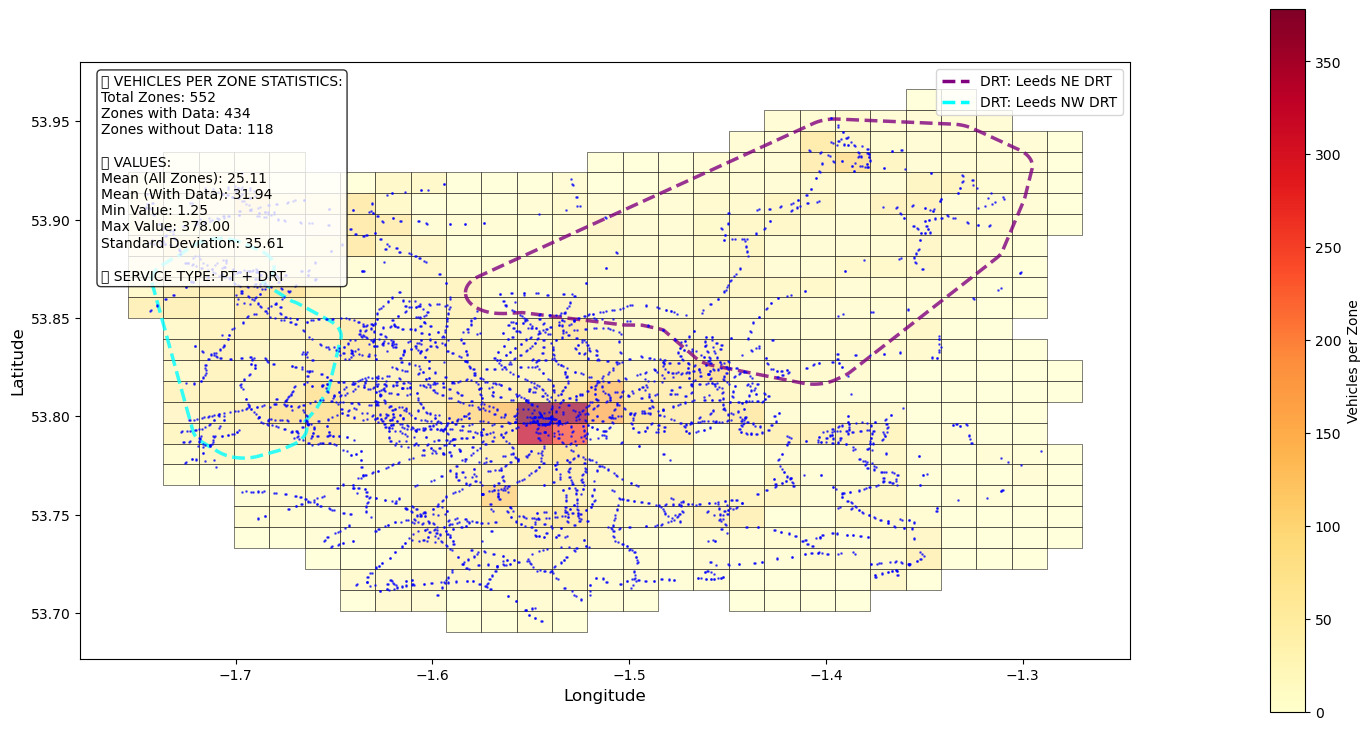

(<Figure size 1500x1200 with 2 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [11]:
coverage_objective.visualize(
    solution_matrix=optimized_solution,
    #optimization_data=opt_data,
    show_stops=True,
    show_drt_zones=True
)

#### Visualise service coverage and waiting times

We compare the service coverage and waiting times before and after optimisation to see how they have changed. The DRT service area polygons are overlaid on the maps to show where DRT is operating.


INFO:transit_opt.optimisation.objectives.base:🗺️ Setting up spatial analysis with 2.0km resolution
INFO:transit_opt.optimisation.spatial.zoning:🗺️  Reprojected 6897 stops to EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 6897 stops...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 6897 → 4405 points
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 4405 stops within boundary
INFO:transit_opt.optimisation.spatial.zoning:🔧 Creating 27 × 26 = 702 grid cells
INFO:transit_opt.optimisation.spatial.zoning:   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
INFO:transit_opt.optimisation.spatial.zoning:   Cell size: 2000.0m × 2000.0m
INFO:transit_opt.optimisation.spatial.zoning:✅ Created 702 hexagonal zones in EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 702 grid cells...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 702 → 552 grid cells
INFO:transit_opt.optimisation.spa


=== COMPREHENSIVE SPATIAL COVERAGE ANALYSIS ===
📊 SPATIAL EQUITY IMPROVEMENTS:
   Objective Value:
     Baseline: 3325.215462
     Optimized: 1267.786615
     Improvement: +61.9%

   Service Coverage:
     Zones with service: 347 → 348 (+1)
     Mean vehicles/zone: 14634.00 → 11462.00

   Service Distribution:
     Variance: 3325.215462 → 1263.799156 (-62.0%)
     Coefficient of variation: 2.175 → 1.712


INFO:transit_opt.optimisation.spatial.zoning:✅ Mapped 4405 stops to zones
INFO:transit_opt.optimisation.spatial.zoning:🗺️ Computing DRT spatial intersections for 2 zones...
INFO:transit_opt.optimisation.spatial.zoning:   Hexagonal grid size: 552 zones
INFO:transit_opt.optimisation.spatial.zoning:Pre-computing route-stop mappings...
INFO:transit_opt.optimisation.spatial.zoning:✅ Cached stops for 187 routes


✅ Spatial system ready: 552 hexagonal zones, metric: variance, time aggregation: average
📊 Using 4 intervals, each 6.0 hours (360 minutes)

   Waiting Time Distribution:
     Mean waiting time: 146.22 → 86.58 min
     Change: -59.64 min

   Vehicle Coverage Distribution:
     Mean vehicles/zone: 26.51 → 25.11
     Change: -1.40 vehicles/zone

🎨 COLOR SCALES:
   Waiting times: 0.3 - 360.0 minutes
   Vehicle coverage: 0.0 - 650.8
   Waiting differences: ±351.4 minutes
   Vehicle differences: ±272.8

📍 Plotting baseline solutions...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting optimized solutions...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting improvement differences...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

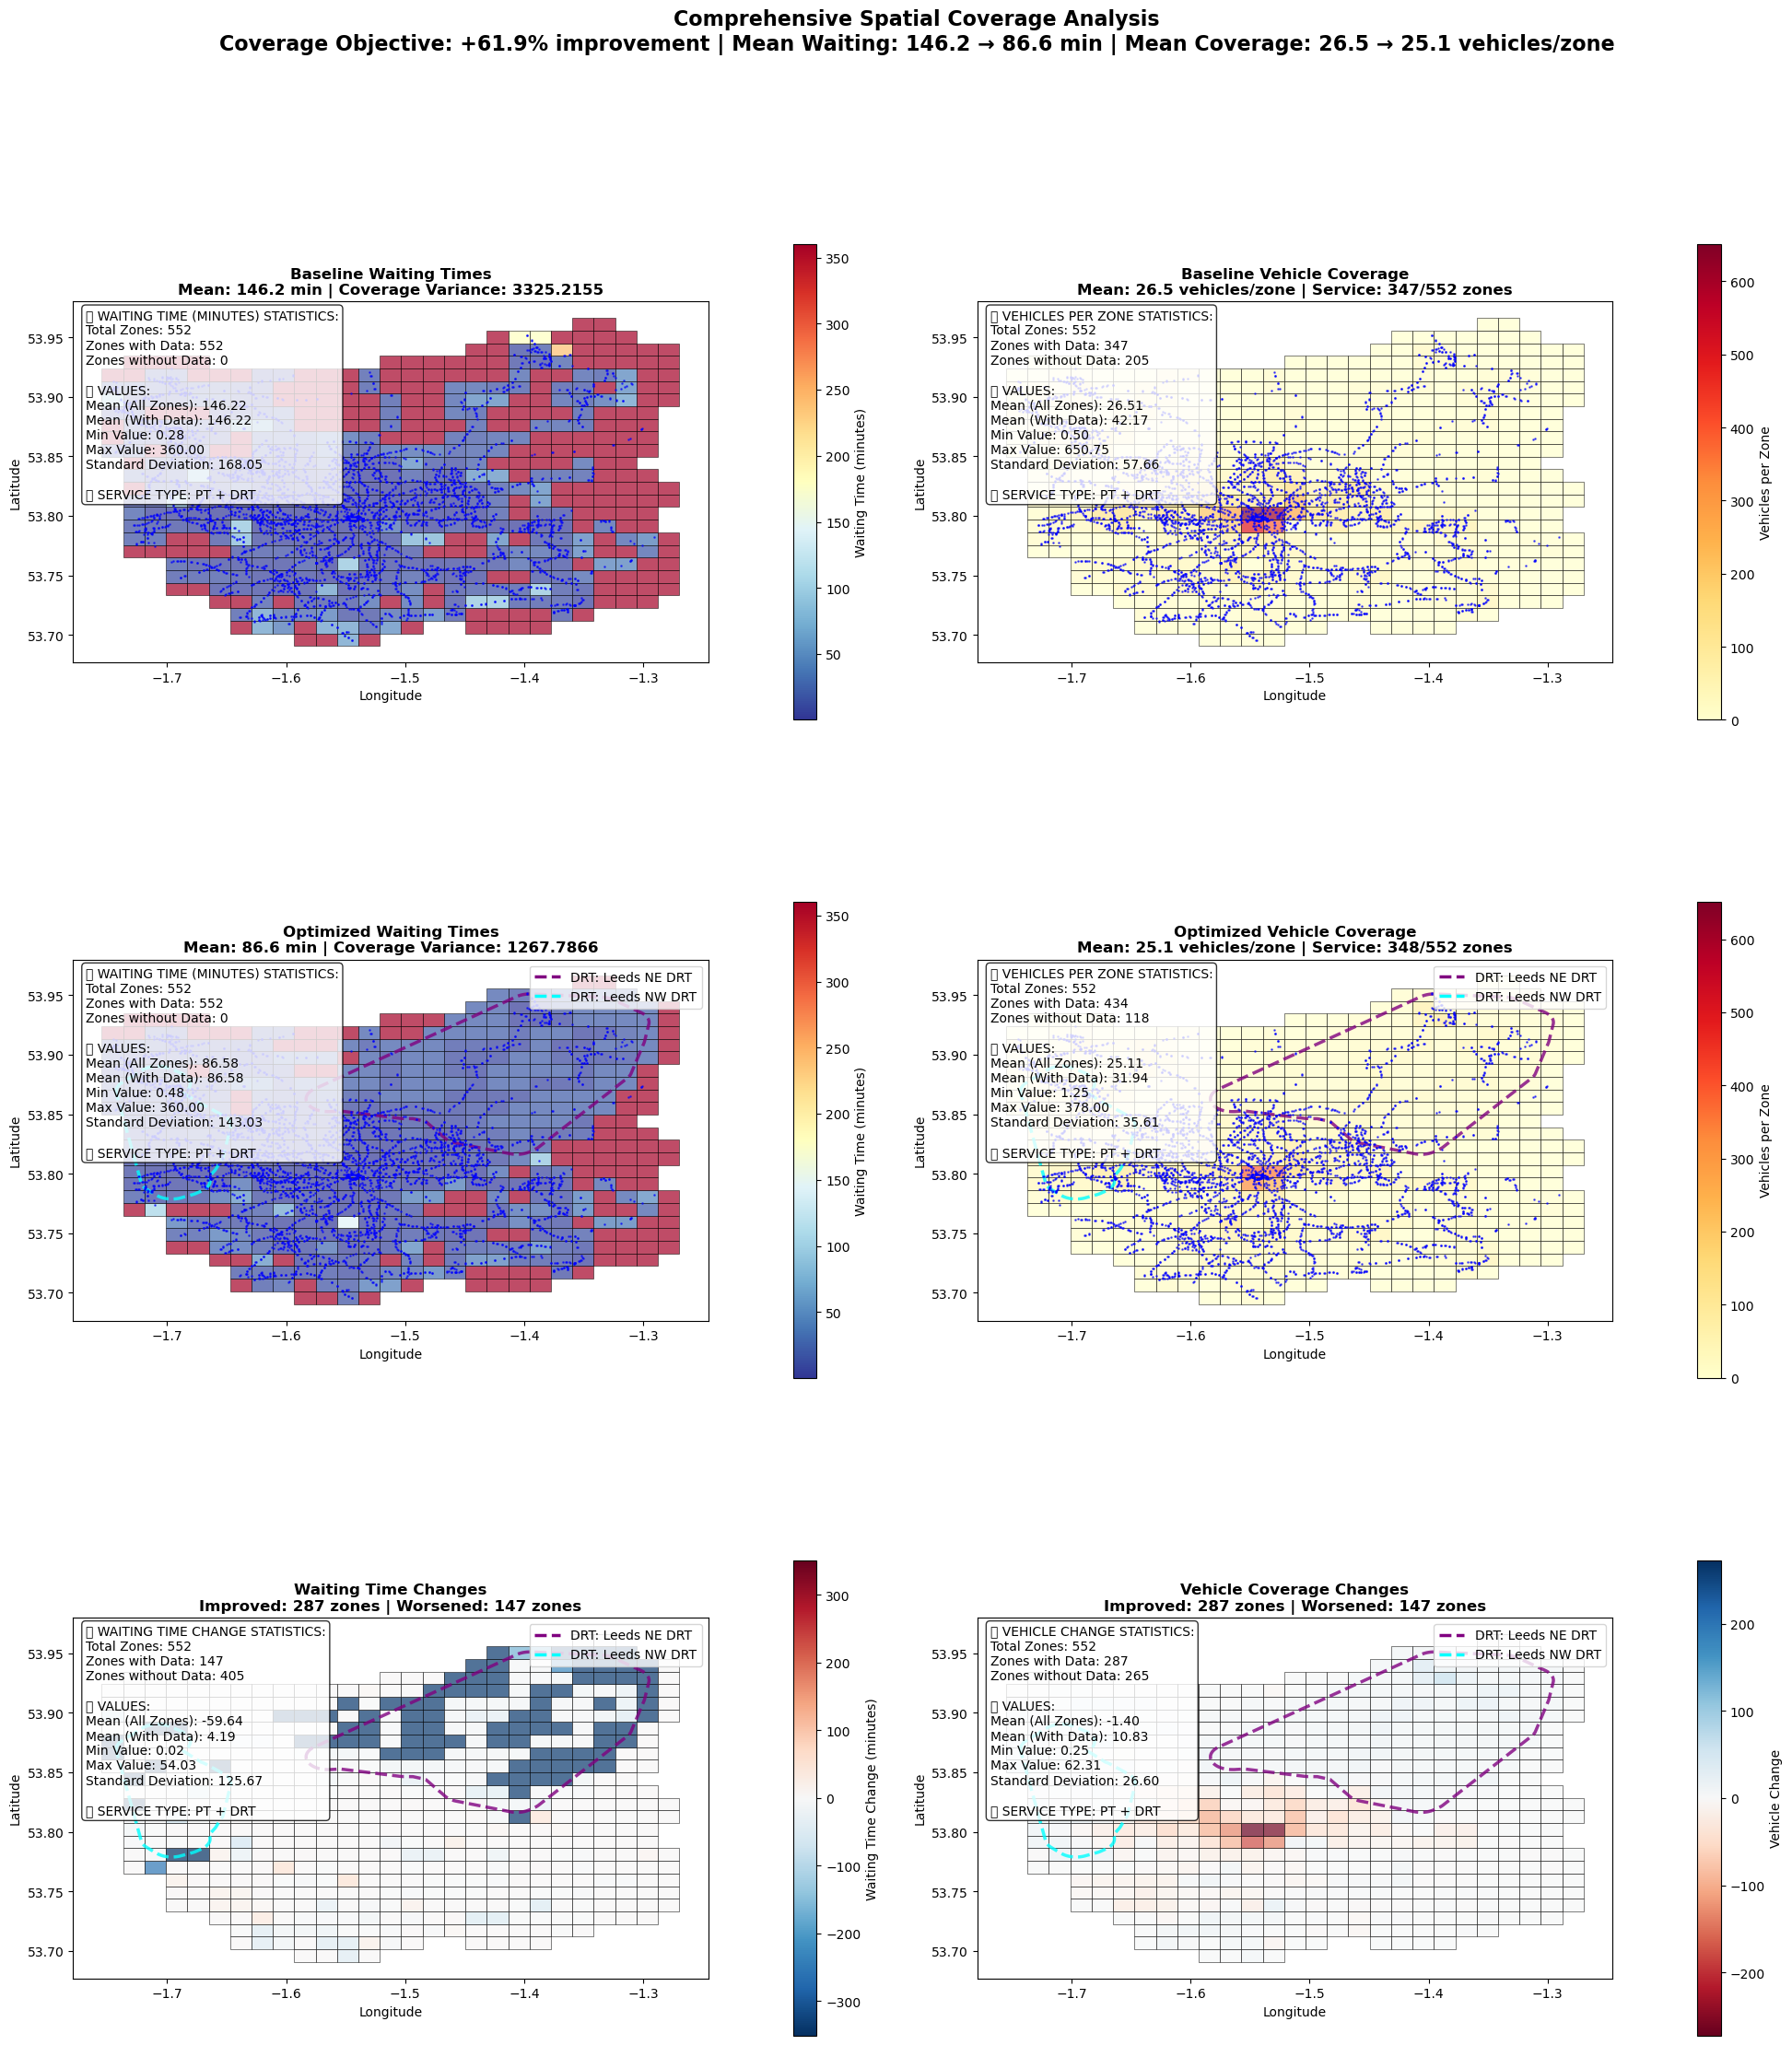


📊 COMPREHENSIVE SPATIAL COVERAGE ANALYSIS SUMMARY:
   🎯 Primary Objective (Spatial Coverage Variance):
      Baseline: 3325.215462 → Optimized: 1267.786615
      Improvement: +61.9%

   ⏱️ Waiting Time Distribution:
      Mean: 146.22 → 86.58 minutes (-59.64)
      Zones with improved waiting: 287/552 (52.0%)

   🚌 Vehicle Coverage Distribution:
      Mean: 26.51 → 25.11 vehicles/zone (-1.40)
      Zones with more vehicles: 287/552 (52.0%)

   📍 Service Coverage:
      Zones with service: 347 → 348 (+1)
      Service coverage: 62.9% → 63.0%

   🏆 Trade-offs Analysis:
      ✅ Spatial coverage improvement achieved (primary objective)
      ⚖️ Waiting time change: -59.64 minutes

✅ Comprehensive spatial coverage analysis completed!
   📈 Top row: Baseline solutions
   📈 Middle row: Optimized solutions
   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)
   🚁 DRT zones shown in optimized and difference plots
   ✔️ Solution satisfies constraints: True
   • 

In [12]:
print("\n=== COMPREHENSIVE SPATIAL COVERAGE ANALYSIS ===")

# Get spatial coverage for baseline and optimized solutions
baseline_coverage_analysis = coverage_objective.get_detailed_analysis(decoded_solution['pt'])
optimized_coverage_analysis = coverage_objective.get_detailed_analysis(optimized_solution['pt'])

print(f"📊 SPATIAL EQUITY IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_coverage_value:.6f}")
print(f"     Optimized: {result_drt_coverage.best_objective:.6f}")
print(f"     Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")

print(f"\n   Service Coverage:")
print(f"     Zones with service: {baseline_coverage_analysis['zones_with_service_average']} → {optimized_coverage_analysis['zones_with_service_average']} ({optimized_coverage_analysis['zones_with_service_average'] - baseline_coverage_analysis['zones_with_service_average']:+d})")
print(f"     Mean vehicles/zone: {baseline_coverage_analysis['total_vehicles_average']:.2f} → {optimized_coverage_analysis['total_vehicles_average']:.2f}")

print(f"\n   Service Distribution:")
print(f"     Variance: {baseline_coverage_analysis['variance_average']:.6f} → {optimized_coverage_analysis['variance_average']:.6f} ({((optimized_coverage_analysis['variance_average'] - baseline_coverage_analysis['variance_average']) / baseline_coverage_analysis['variance_average'] * 100):+.1f}%)")
print(f"     Coefficient of variation: {baseline_coverage_analysis['coefficient_of_variation_average']:.3f} → {optimized_coverage_analysis['coefficient_of_variation_average']:.3f}")

# Calculate waiting times (for column 1) - need to create waiting time objective
from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective

# Create temporary waiting time objective for visualization
temp_waiting_objective = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,
    boundary=study_boundary,
    metric="variance",
    crs="EPSG:3857",
    time_aggregation="average",
    population_weighted=False
)

# Calculate waiting times for both solutions
baseline_waiting_times = temp_waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = temp_waiting_objective.get_waiting_times_per_zone(optimized_solution, "average")

# Calculate spatial coverage (for column 2)
baseline_vehicles = coverage_objective.spatial_system._vehicles_per_zone(decoded_solution['pt'], opt_data)['average']
optimized_vehicles = coverage_objective.spatial_system._vehicles_per_zone(optimized_solution, opt_data)['average']

# Calculate differences
waiting_difference = optimized_waiting_times - baseline_waiting_times  # Negative = improvement
vehicle_difference = optimized_vehicles - baseline_vehicles  # Positive = improvement

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
baseline_mean_vehicles = np.mean(baseline_vehicles)
optimized_mean_vehicles = np.mean(optimized_vehicles)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} min")

print(f"\n   Vehicle Coverage Distribution:")
print(f"     Mean vehicles/zone: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f}")
print(f"     Change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")

# Determine shared color scales for fair comparison
waiting_vmin = min(baseline_waiting_times.min(), optimized_waiting_times.min())
waiting_vmax = max(baseline_waiting_times.max(), optimized_waiting_times.max())
vehicle_vmin = min(baseline_vehicles.min(), optimized_vehicles.min())
vehicle_vmax = max(baseline_vehicles.max(), optimized_vehicles.max())

# For difference plots, use symmetric scale around zero
waiting_diff_max = max(abs(waiting_difference.min()), abs(waiting_difference.max()))
vehicle_diff_max = max(abs(vehicle_difference.min()), abs(vehicle_difference.max()))

print(f"\n🎨 COLOR SCALES:")
print(f"   Waiting times: {waiting_vmin:.1f} - {waiting_vmax:.1f} minutes")
print(f"   Vehicle coverage: {vehicle_vmin:.1f} - {vehicle_vmax:.1f}")
print(f"   Waiting differences: ±{waiting_diff_max:.1f} minutes")
print(f"   Vehicle differences: ±{vehicle_diff_max:.1f}")

# Create comprehensive 3x2 visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# Configure overall title
overall_title = (
    f"Comprehensive Spatial Coverage Analysis\n"
    f"Coverage Objective: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}% improvement | "
    f"Mean Waiting: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} min | "
    f"Mean Coverage: {baseline_mean_vehicles:.1f} → {optimized_mean_vehicles:.1f} vehicles/zone"
)
fig.suptitle(overall_title, fontsize=16, fontweight='bold', y=0.995)

# Row 1: Baseline Solutions
print("\n📍 Plotting baseline solutions...")

# Row 1, Col 1: Baseline Waiting Times
temp_waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 0],
    show_stops=True,
    show_drt_zones=False,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[0, 0].set_title(f'Baseline Waiting Times\nMean: {baseline_mean_waiting:.1f} min | Coverage Variance: {baseline_coverage_value:.4f}',
                     fontsize=12, fontweight='bold')

# Row 1, Col 2: Baseline Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 1],
    show_stops=True,
    show_drt_zones=False,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
zones_with_service = baseline_coverage_analysis['zones_with_service_average']
total_zones = len(coverage_objective.spatial_system.hex_grid)
axes[0, 1].set_title(f'Baseline Vehicle Coverage\nMean: {baseline_mean_vehicles:.1f} vehicles/zone | Service: {zones_with_service}/{total_zones} zones',
                     fontsize=12, fontweight='bold')

# Row 2: Optimized Solutions
print("📍 Plotting optimized solutions...")

# Row 2, Col 1: Optimized Waiting Times
temp_waiting_objective.visualize(
    solution_matrix=optimized_solution,
    ax=axes[1, 0],
    show_stops=True,
    show_drt_zones=True,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[1, 0].set_title(f'Optimized Waiting Times\nMean: {optimized_mean_waiting:.1f} min | Coverage Variance: {result_drt_coverage.best_objective:.4f}',
                     fontsize=12, fontweight='bold')

# Row 2, Col 2: Optimized Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=optimized_solution,
    ax=axes[1, 1],
    show_stops=True,
    show_drt_zones=True,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
optimized_zones_with_service = optimized_coverage_analysis['zones_with_service_average']
axes[1, 1].set_title(f'Optimized Vehicle Coverage\nMean: {optimized_mean_vehicles:.1f} vehicles/zone | Service: {optimized_zones_with_service}/{total_zones} zones',
                     fontsize=12, fontweight='bold')

# Row 3: Differences (Improvements)
print("📍 Plotting improvement differences...")

# Row 3, Col 1: Waiting Time Difference (Optimized - Baseline)
# Negative values = improvement (shorter waiting times)
zones_with_waiting_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_waiting_diff["waiting_change"] = waiting_difference
zones_geo_waiting = zones_with_waiting_diff.to_crs("EPSG:4326")

zones_geo_waiting.plot(
    ax=axes[2, 0],
    column="waiting_change",
    cmap="RdBu_r",  # Red=increase (worse), Blue=decrease (better)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-waiting_diff_max,
    vmax=waiting_diff_max,
    legend_kwds={
        "label": "Waiting Time Change (minutes)",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 0], opt_data, True)
waiting_stats_text = coverage_objective.spatial_system._create_data_stats_text(waiting_difference, "Waiting Time Change", opt_data)
axes[2, 0].text(0.02, 0.98, waiting_stats_text, transform=axes[2, 0].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_waiting = np.sum(waiting_difference < 0)
zones_worsened_waiting = np.sum(waiting_difference > 0)
axes[2, 0].set_title(f'Waiting Time Changes\nImproved: {zones_improved_waiting} zones | Worsened: {zones_worsened_waiting} zones',
                     fontsize=12, fontweight='bold')

# Row 3, Col 2: Vehicle Coverage Difference (Optimized - Baseline)
# Positive values = improvement (more vehicles)
zones_with_vehicle_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_vehicle_diff["vehicle_change"] = vehicle_difference
zones_geo_vehicles = zones_with_vehicle_diff.to_crs("EPSG:4326")

zones_geo_vehicles.plot(
    ax=axes[2, 1],
    column="vehicle_change",
    cmap="RdBu",  # Red=increase (better), Blue=decrease (worse)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-vehicle_diff_max,
    vmax=vehicle_diff_max,
    legend_kwds={
        "label": "Vehicle Change",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 1], opt_data, True)
vehicle_stats_text = coverage_objective.spatial_system._create_data_stats_text(vehicle_difference, "Vehicle Change", opt_data)
axes[2, 1].text(0.02, 0.98, vehicle_stats_text, transform=axes[2, 1].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_vehicles = np.sum(vehicle_difference > 0)
zones_worsened_vehicles = np.sum(vehicle_difference < 0)
axes[2, 1].set_title(f'Vehicle Coverage Changes\nImproved: {zones_improved_vehicles} zones | Worsened: {zones_worsened_vehicles} zones',
                     fontsize=12, fontweight='bold')

# Add geographic labels to all subplots
for i in range(3):
    for j in range(2):
        axes[i, j].set_xlabel("Longitude", fontsize=10)
        axes[i, j].set_ylabel("Latitude", fontsize=10)
        axes[i, j].set_aspect("equal")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.96)  # Make room for overall title
plt.show()

# Print comprehensive summary
print(f"\n📊 COMPREHENSIVE SPATIAL COVERAGE ANALYSIS SUMMARY:")
print(f"   🎯 Primary Objective (Spatial Coverage Variance):")
print(f"      Baseline: {baseline_coverage_value:.6f} → Optimized: {result_drt_coverage.best_objective:.6f}")
print(f"      Improvement: {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")

print(f"\n   ⏱️ Waiting Time Distribution:")
print(f"      Mean: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} minutes ({optimized_mean_waiting - baseline_mean_waiting:+.2f})")
print(f"      Zones with improved waiting: {zones_improved_waiting}/{len(baseline_waiting_times)} ({100*zones_improved_waiting/len(baseline_waiting_times):.1f}%)")

print(f"\n   🚌 Vehicle Coverage Distribution:")
print(f"      Mean: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f} vehicles/zone ({optimized_mean_vehicles - baseline_mean_vehicles:+.2f})")
print(f"      Zones with more vehicles: {zones_improved_vehicles}/{len(baseline_vehicles)} ({100*zones_improved_vehicles/len(baseline_vehicles):.1f}%)")

print(f"\n   📍 Service Coverage:")
service_change = optimized_zones_with_service - zones_with_service
print(f"      Zones with service: {zones_with_service} → {optimized_zones_with_service} ({service_change:+d})")
print(f"      Service coverage: {100*zones_with_service/total_zones:.1f}% → {100*optimized_zones_with_service/total_zones:.1f}%")

print(f"\n   🏆 Trade-offs Analysis:")
if optimized_mean_waiting < baseline_mean_waiting and optimized_mean_vehicles > baseline_mean_vehicles:
    print("      ✅ Win-Win: Both waiting times decreased AND vehicle coverage increased")
elif result_drt_coverage.best_objective < baseline_coverage_value:
    print("      ✅ Spatial coverage improvement achieved (primary objective)")
    print(f"      ⚖️ Waiting time change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} minutes")
else:
    print("      ⚠️ Complex trade-offs detected - review spatial patterns above")

print(f"\n✅ Comprehensive spatial coverage analysis completed!")
print(f"   📈 Top row: Baseline solutions")
print(f"   📈 Middle row: Optimized solutions")
print(f"   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)")
print(f"   🚁 DRT zones shown in optimized and difference plots")
print(f"   ✔️ Solution satisfies constraints: {result_drt_coverage.constraint_violations['feasible']}")
print(f"   • Spatial equity improved by {((baseline_coverage_value - result_drt_coverage.best_objective) / baseline_coverage_value * 100):+.1f}%")
print(f"   • DRT fleet deployment optimized across {opt_data['n_drt_zones']} zones")

### Objective B: Minimise total Waiting Time across all zones

In [13]:
from transit_opt.optimisation.objectives.waiting_time import WaitingTimeObjective

# Create waiting time objective
waiting_objective = WaitingTimeObjective(
    optimization_data=opt_data,
    spatial_resolution_km=2.0,
    boundary=study_boundary,
    metric="total",                 # Minimize variance in waiting time
    crs="EPSG:3857",
    time_aggregation="average",
    population_weighted=False
)

print(f"✅ Waiting time objective created:")
print(f"   Metric: {waiting_objective.metric}")
print(f"   Time aggregation: {waiting_objective.time_aggregation}")

# Evaluate baseline waiting time
baseline_waiting_value = waiting_objective.evaluate(decoded_solution['pt'])
print(f"\n📊 BASELINE WAITING TIME PERFORMANCE:")
print(f"   Objective value (variance): {baseline_waiting_value:.2f} minutes²")

# Quick optimization test with waiting time objective
config_waiting_drt = {
    'problem': {
        'objective': {
            'type': 'WaitingTimeObjective',
            'spatial_resolution_km': 2.0,
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'metric': 'variance',
            'time_aggregation': 'average',
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.55,  # Maintain 85% of current PT service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.2, # Initial fleet + (tolerance * initial fleet) = max fleet   (Calculated per interval)
                'allow_borrowing': False
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 30,  # Small for quick test
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False
        },
        'termination': {'max_generations': 25},  # Quick test
        'monitoring': {'progress_frequency': 5, 'save_history': True}
    }
}

print(f"\n🚀 Running quick waiting time optimization test...")
config_manager_waiting_drt = OptimizationConfigManager(config_dict=config_waiting_drt)
pso_runner_waiting_drt = PSORunner(config_manager_waiting_drt)

# Create new problem with waiting time objective
waiting_problem = TransitOptimizationProblem(
    optimization_data=opt_data,
    objective=waiting_objective
)

result_waiting_drt = pso_runner_waiting_drt.optimize(opt_data, track_best_n=3)

print(f"\n✅ WAITING TIME OPTIMIZATION RESULTS:")
print(f"   Runtime: {result_waiting_drt.optimization_time:.1f} seconds")
print(f"   Best objective: {result_waiting_drt.best_objective:.2f} minutes²")
print(f"   Baseline objective: {baseline_waiting_value:.2f} minutes²")
print(f"   Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")
print(f"   Feasible: {'✅' if result_waiting_drt.constraint_violations['feasible'] else '❌'}")


INFO:transit_opt.optimisation.objectives.base:🗺️ Setting up spatial analysis with 2.0km resolution
INFO:transit_opt.optimisation.spatial.zoning:🗺️  Reprojected 6897 stops to EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 6897 stops...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 6897 → 4405 points
INFO:transit_opt.optimisation.spatial.zoning:✅ Filtered to 4405 stops within boundary
INFO:transit_opt.optimisation.spatial.zoning:🔧 Creating 27 × 26 = 702 grid cells
INFO:transit_opt.optimisation.spatial.zoning:   Grid bounds: (-195346, 7111759) to (-142657, 7161976) meters
INFO:transit_opt.optimisation.spatial.zoning:   Cell size: 2000.0m × 2000.0m
INFO:transit_opt.optimisation.spatial.zoning:✅ Created 702 hexagonal zones in EPSG:3857
INFO:transit_opt.optimisation.spatial.zoning:🎯 Applying boundary filter to 702 grid cells...
INFO:transit_opt.optimisation.spatial.boundaries:🔍 Filtered 702 → 552 grid cells
INFO:transit_opt.optimisation.spa

✅ Spatial system ready: 552 hexagonal zones, metric: total, time aggregation: average
✅ Waiting time objective created:
   Metric: total
   Time aggregation: average
📊 Using 4 intervals, each 6.0 hours (360 minutes)
   Metric: total
   Waiting times shape: (552,)
   Sample waiting times: [ 11.42857143 360.         360.           6.37168142  90.
  12.20338983 360.         360.          13.58490566  10.90909091]
   Min/Max waiting times: 0.28/360.00
   Unweighted total result: 80711.47893508375

📊 BASELINE WAITING TIME PERFORMANCE:
   Objective value (variance): 80711.48 minutes²

🚀 Running quick waiting time optimization test...
📋 Using provided configuration dictionary


INFO:transit_opt.optimisation.spatial.zoning:✅ Mapped 4405 stops to zones
INFO:transit_opt.optimisation.spatial.zoning:🗺️ Computing DRT spatial intersections for 2 zones...
INFO:transit_opt.optimisation.spatial.zoning:   Hexagonal grid size: 552 zones
INFO:transit_opt.optimisation.spatial.zoning:Pre-computing route-stop mappings...
INFO:transit_opt.optimisation.spatial.zoning:✅ Cached stops for 187 routes
INFO:transit_opt.optimisation.runners.pso_runner:   📋 Creating 3 constraint handler(s)...
INFO:transit_opt.optimisation.runners.pso_runner:      Creating constraint 1: FleetTotalConstraintHandler
INFO:transit_opt.optimisation.runners.pso_runner:         ✓ FleetTotal: 1 constraint(s)
INFO:transit_opt.optimisation.runners.pso_runner:      Creating constraint 2: MinimumFleetConstraintHandler
INFO:transit_opt.optimisation.runners.pso_runner:         ✓ MinimumFleet: 1 constraint(s)
INFO:transit_opt.optimisation.runners.pso_runner:      Creating constraint 3: FleetPerIntervalConstraintHandl

✅ Spatial system ready: 552 hexagonal zones, metric: variance, time aggregation: average
📊 Using 4 intervals, each 6.0 hours (360 minutes)
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  1.56862745   1.92         1.92         6.99029126   9.
   6.20689655 360.         360.          10.74626866   1.76470588]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 20774.9871990552
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.24882874   3.14181818   3.14181818   6.85714286   9.6
   8.37209302 360.         360.          12.4137931    2.8439763 ]
   Min/Max waiting times: 0.54/360.00
   Unweighted variance result: 20486.97118242335
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  1.95829556   2.46857143   2.46857143   7.27272727   8.88888889
   5.85365854 360.         360.          13.09090909   2.23834197]
   Min/Max waiting times: 0.51/360.00
   Unweighted variance result: 20786.8

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19705.952060717565,
                        • Worst objective 20832.053717195686,
                        • Average objective 20526.404577731657
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 2/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:


   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.47990815   3.456        3.456        8.47058824  10.90909091
   8.6746988  360.         360.          15.31914894   2.84210526]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 20684.373458343598
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.38653367  17.28        17.28         6.20689655  10.43478261
   8.6746988  360.         360.          10.74626866  10.33492823]
   Min/Max waiting times: 0.51/360.00
   Unweighted variance result: 20534.978277320857
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.31797235   5.76         5.76         6.85714286  12.63157895
   9.8630137  360.         360.          15.65217391   4.04494382]
   Min/Max waiting times: 0.53/360.00
   Unweighted variance result: 20487.684593670536
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.01465457   4.93714286   4.93

INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 2/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 2/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 1 (06-12h): 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 2 (12-18h): 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 3 (18-24h): 30/30 solutions


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       30 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  0.000000E+00 |  8.636667E+01 |  2.048970E+04 |  2.029503E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  1.80753138   2.16         2.16         9.          11.61290323
   7.91208791 360.         360.          14.11764706   2.00930233]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20524.053205286935
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.01869159   2.46857143   2.46857143   8.6746988   12.20338983
   9.6        360.         360.          15.31914894   2.30277186]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20539.690201619425
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.28571429   2.88         2.88         9.72972973  11.612

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19827.32567236906,
                        • Worst objective 20676.20205004769,
                        • Average objective 20394.46403614729
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 5/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 5/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisatio

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.87096774   5.76         5.76         9.47368421  11.25
   9.35064935 360.         360.          13.84615385   4.89795918]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20422.24144757665
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.19512195   2.88         2.88         8.7804878   15.31914894
  10.28571429 360.         360.          15.31914894   2.58992806]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20372.20654837545
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.36973479   4.32         4.32         7.65957447  11.07692308
   9.11392405 360.         360.          12.4137931    3.71772806]
   Min/Max waiting times: 0.61/360.00
   Unweighted variance result: 20158.38882519008
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  1.90224571   2.304        2.304        

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20156.46158339958,
                        • Worst objective 20501.178618965652,
                        • Average objective 20333.428452469536
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 2/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 2/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisat

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.84960422   4.32         4.32         7.91208791  16.
  10.28571429 360.         360.          20.57142857   3.67972743]
   Min/Max waiting times: 0.67/360.00
   Unweighted variance result: 20447.84421200977
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.65482234   5.76         5.76        10.43478261  14.11764706
  11.42857143 360.         360.          17.14285714   4.86486486]
   Min/Max waiting times: 0.73/360.00
   Unweighted variance result: 20308.57100740488
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.99168975   4.32         4.32         9.11392405  17.14285714
  11.42857143 360.         360.          18.           3.73702422]
   Min/Max waiting times: 0.71/360.00
   Unweighted variance result: 20391.655365106024
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.36710834   4.93714286   4.93714286   8

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20163.99883926623,
                        • Worst objective 20578.05302770218,
                        • Average objective 20333.564523517296
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 3/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 3/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisati

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.00417246   4.32         4.32         7.82608696  14.69387755
  10.         360.         360.          19.45945946   3.67972743]
   Min/Max waiting times: 0.67/360.00
   Unweighted variance result: 20311.927741476396
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.6030025    4.93714286   4.93714286   8.88888889  12.20338983
   8.88888889 360.         360.          14.69387755   4.00370714]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20290.727284763867
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.17522659   2.88         2.88         9.35064935  15.
  10.90909091 360.         360.          14.4          2.60869565]
   Min/Max waiting times: 0.69/360.00
   Unweighted variance result: 20205.708694308894
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.68915457   6.912        6.912       

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19655.49106156862,
                        • Worst objective 20519.128013475263,
                        • Average objective 20315.385153120245
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 12/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 12/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.94277929   4.32         4.32         8.88888889  16.
  10.90909091 360.         360.          14.69387755   3.69863014]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 20426.312401771265
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.08131241   4.32         4.32         9.11392405  12.
   8.27586207 360.         360.          12.63157895   3.67972743]
   Min/Max waiting times: 0.63/360.00
   Unweighted variance result: 20120.50159732199
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.81616688   4.32         4.32         7.91208791  10.74626866
   7.65957447 360.         360.          12.63157895   3.75652174]
   Min/Max waiting times: 0.65/360.00
   Unweighted variance result: 20224.13073159803
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.68915457   6.912        6.912        9.6      

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20075.32081667243,
                        • Worst objective 20446.677135903792,
                        • Average objective 20235.76410695523
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 15/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 15/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisa

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.87096774   5.76         5.76         9.6         10.74626866
   9.35064935 360.         360.          13.84615385   4.86486486]
   Min/Max waiting times: 0.68/360.00
   Unweighted variance result: 20102.050435377143
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.36710834   4.93714286   4.93714286   9.6         13.33333333
   9.47368421 360.         360.          13.84615385   4.09478673]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 20210.872595197623
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.08131241   4.32         4.32         9.11392405  12.
   8.27586207 360.         360.          12.63157895   3.67972743]
   Min/Max waiting times: 0.63/360.00
   Unweighted variance result: 20120.50159732199
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.39889851   4.93714286   4.93714286   

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20075.32081667243,
                        • Worst objective 20433.94638141305,
                        • Average objective 20249.950930974053
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 14/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 14/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisa

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.85026738   5.76         5.76        10.28571429  12.85714286
   9.         360.         360.          12.63157895   4.55696203]
   Min/Max waiting times: 0.61/360.00
   Unweighted variance result: 20123.82093549335
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  2.7961165    3.84         3.84         9.72972973  14.4
   8.57142857 360.         360.          14.4          3.35664336]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 20367.619562778425
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.82978723   5.76         5.76        11.42857143  13.58490566
   8.7804878  360.         360.          13.33333333   4.67532468]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 20101.400134248674
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.2814668    6.912        6.912       

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20047.221157635893,
                        • Worst objective 20516.93643392242,
                        • Average objective 20252.911792657036
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 14/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 14/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.24271845   8.64         8.64         9.72972973  13.33333333
  10.14084507 360.         360.          14.11764706   6.46706587]
   Min/Max waiting times: 0.66/360.00
   Unweighted variance result: 20047.221157635893
     8 |      240 | -4.2E-02 |       3 |  0.3738 |  1.94415 |  2.08059 |  0.000000E+00 |  3.8833333333 |  2.020849E+04 |  2.007532E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.58506224   4.93714286   4.93714286   9.6         12.20338983
   8.47058824 360.         360.          14.11764706   4.09478673]
   Min/Max waiting times: 0.68/360.00
   Unweighted variance result: 20459.76052312618
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.82978723   5.76         5.76         9.23076923  12.
   7.82608696 360.         360.          13.84615385   4.52830189]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 20

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 20066.588414623457,
                        • Worst objective 20481.205981914158,
                        • Average objective 20228.76604531275
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 16/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 16/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.13397129   6.912        6.912        9.6         14.11764706
   8.7804878  360.         360.          14.69387755   5.36645963]
   Min/Max waiting times: 0.64/360.00
   Unweighted variance result: 20281.312194241505
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.46742503   6.912        6.912       10.28571429  13.33333333
   8.37209302 360.         360.          14.4          5.40675845]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 20075.32081667243
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.60554371   8.64         8.64         8.7804878   12.63157895
   8.7804878  360.         360.          14.4          6.24277457]
   Min/Max waiting times: 0.59/360.00
   Unweighted variance result: 20129.25648961323
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.332999     6.912        6.912 

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19641.707908709242,
                        • Worst objective 20452.61265880316,
                        • Average objective 20122.154807864794
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 16/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 16/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.44772546   4.93714286   4.93714286   7.34693878  12.20338983
   8.18181818 360.         360.          14.4          4.16586307]
   Min/Max waiting times: 0.64/360.00
   Unweighted variance result: 19641.707908709242
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.85026738   5.76         5.76         9.47368421  15.
   9.         360.         360.          11.61290323   4.58598726]
   Min/Max waiting times: 0.61/360.00
   Unweighted variance result: 20095.906735235327
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.73056995   5.76         5.76         8.88888889  15.65217391
  10.43478261 360.         360.          12.20338983   4.52830189]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 19908.539098009864
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.78947368   5.76         5.76        

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19864.27152312059,
                        • Worst objective 20365.522446500105,
                        • Average objective 20031.235265217005
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 15/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 15/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.08703879   6.912        6.912        9.          13.33333333
   8.6746988  360.         360.          13.58490566   5.48919949]
   Min/Max waiting times: 0.62/360.00
   Unweighted variance result: 19925.765834207337
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.12138728   4.32         4.32        10.          13.58490566
   8.37209302 360.         360.          13.09090909   3.71772806]
   Min/Max waiting times: 0.63/360.00
   Unweighted variance result: 20027.455078682815
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.01860465   6.912        6.912       10.43478261  16.36363636
   9.47368421 360.         360.          12.63157895   5.32675709]
   Min/Max waiting times: 0.60/360.00
   Unweighted variance result: 19911.125916259633
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.65482234   5.76         5.76

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19881.187336228926,
                        • Worst objective 20358.669839919785,
                        • Average objective 20031.658486385306
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 26/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 26/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.51219512   5.76         5.76        10.74626866  16.74418605
  10.         360.         360.          11.25         4.52830189]
   Min/Max waiting times: 0.60/360.00
   Unweighted variance result: 20091.839188448543
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.04115996   6.912        6.912       10.74626866  16.
   9.8630137  360.         360.          13.09090909   5.2490887 ]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19910.68344638032
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.13397129   6.912        6.912        9.72972973  14.4
   9.35064935 360.         360.          13.09090909   5.53137004]
   Min/Max waiting times: 0.64/360.00
   Unweighted variance result: 20222.580953993383
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.35483871   8.64         8.64        10.43478

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19752.786426965627,
                        • Worst objective 20321.09971505874,
                        • Average objective 19962.315952464232
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 28/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 28/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.20642648   6.912        6.912        8.08988764  12.85714286
   8.6746988  360.         360.          13.33333333   5.40675845]
   Min/Max waiting times: 0.60/360.00
   Unweighted variance result: 19897.12368391613
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.67346939   5.76         5.76         8.88888889  15.31914894
  10.43478261 360.         360.          13.33333333   4.55696203]
   Min/Max waiting times: 0.60/360.00
   Unweighted variance result: 19923.415307105628
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.11037108   6.912        6.912        9.35064935  16.
  10.58823529 360.         360.          12.           5.17365269]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 20076.621662248643
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.51882845   8.64         8.64         

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19436.401771566623,
                        • Worst objective 20243.720086900048,
                        • Average objective 19766.948011172462
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.75         5.76         5.76         9.6         15.
   9.6        360.         360.          10.90909091   4.47204969]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19846.932985173495
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.63636364   5.76         5.76         8.88888889  13.84615385
  10.28571429 360.         360.          10.43478261   4.61538462]
   Min/Max waiting times: 0.61/360.00
   Unweighted variance result: 19613.09858198984
    14 |      420 | -2.8E-02 |       3 |  0.3830 |  1.88586 |  2.13411 |  0.000000E+00 |  0.000000E+00 |  1.976355E+04 |  1.943640E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.54736842   8.64         8.64         9.23076923  13.58490566
   8.7804878  360.         360.          10.           6.03351955]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 19

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19405.144992870453,
                        • Worst objective 20135.848650798733,
                        • Average objective 19637.89837172348
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.97424103   6.912        6.912       10.28571429  15.65217391
   9.6        360.         360.          11.80327869   5.17365269]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19423.05434684576
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.57627119   8.64         8.64         9.8630137   16.
   9.72972973 360.         360.          10.28571429   5.9833795 ]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 19405.716614068835
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.78935698   8.64         8.64        10.          15.
   9.47368421 360.         360.           9.6          6.18911175]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19405.144992870453
    15 |      450 | -5.2E-02 |       3 |  0.3682 |  1.87837 |  2.14185 |  0.000000E+00 |  0.000000E+00 |  1.961121E+04 |  1.94

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19392.03278989196,
                        • Worst objective 20047.873855066147,
                        • Average objective 19508.233452693286
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 29/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 29/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 29/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.65482234   5.76         5.76        10.          16.
   9.72972973 360.         360.          10.28571429   4.64516129]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19649.639459230653
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.04115996   6.912        6.912        9.8630137   14.69387755
   9.35064935 360.         360.          10.43478261   5.10035419]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19436.55020354974
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.08703879   6.912        6.912       10.14084507  14.69387755
   9.35064935 360.         360.          10.14084507   5.10035419]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19439.41775985077
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.08703879   6.912        6.912        8

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19378.41143011731,
                        • Worst objective 20167.449714568553,
                        • Average objective 19471.89035732806
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisa

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.78947368   5.76         5.76         9.35064935  13.33333333
   8.88888889 360.         360.          12.20338983   4.64516129]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19624.370160592633
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.38557994   4.32         4.32         8.7804878   14.69387755
   9.47368421 360.         360.          12.           3.62416107]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 19451.724677009137
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.55216017   6.912        6.912        9.6         13.33333333
   8.88888889 360.         360.          10.28571429   5.21109771]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19421.143640451286
    17 |      510 | -3.7E-02 |       3 |  0.3769 |  1.86100 |  2.16239 |  0.000000E+00 |  0.000000E+00 |  1.9

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19351.736286982312,
                        • Worst objective 20081.119841271153,
                        • Average objective 19511.396592388086
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.85393258   8.64         8.64         9.11392405  13.58490566
   9.         360.         360.           9.8630137    6.18911175]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19603.644951058828
    18 |      540 | -4.3E-02 |       3 |  0.3737 |  1.85289 |  2.17107 |  0.000000E+00 |  0.000000E+00 |  1.942493E+04 |  1.935174E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.05854801   8.64         8.64        10.14084507  14.11764706
   9.23076923 360.         360.          10.43478261   6.13636364]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19367.389590149953
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.7007617    6.912        6.912        9.          13.58490566
   9.11392405 360.         360.          10.14084507   5.2490887 ]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance r

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19340.9175826132,
                        • Worst objective 20071.37444749999,
                        • Average objective 19592.674983274013
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimisat

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  6.0251046   11.52        11.52         9.72972973  15.
   9.72972973 360.         360.          10.28571429   7.53926702]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 20027.86213081444
    19 |      570 | -6.2E-02 |       3 |  0.3620 |  1.84389 |  2.17486 |  0.000000E+00 |  0.000000E+00 |  1.938546E+04 |  1.934092E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.20481928   8.64         8.64         9.8630137   15.31914894
   9.72972973 360.         360.          10.14084507   6.24277457]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 20026.73020148677
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.49531738   6.912        6.912        9.47368421  14.69387755
   9.47368421 360.         360.          10.74626866   5.36645963]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 193

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19302.336386492043,
                        • Worst objective 20059.603280805495,
                        • Average objective 19479.577030941826
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.332999     6.912        6.912        9.72972973  13.58490566
   8.88888889 360.         360.          10.28571429   5.36645963]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19371.683874137438
    20 |      600 | -6.2E-02 |       3 |  0.3618 |  1.83876 |  2.18702 |  0.000000E+00 |  0.000000E+00 |  1.936281E+04 |  1.930234E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.46742503   6.912        6.912        9.          13.09090909
   8.88888889 360.         360.          10.           5.2876377 ]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19367.4078546806
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.20481928   8.64         8.64         9.72972973  15.
   9.6        360.         360.          10.14084507   6.29737609]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 199

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19299.085579310693,
                        • Worst objective 20038.66976833979,
                        • Average objective 19535.584949363772
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.28117359   8.64         8.64         8.7804878   13.09090909
   8.7804878  360.         360.          11.42857143   6.29737609]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 20007.594941513817
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.49797571   4.93714286   4.93714286   9.35064935  13.84615385
   9.         360.         360.          10.74626866   4.09478673]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19359.795822173255
    21 |      630 | -4.4E-02 |       3 |  0.3726 |  1.82921 |  2.19000 |  0.000000E+00 |  0.000000E+00 |  1.934302E+04 |  1.929909E+04
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.16746411   8.64         8.64         9.35064935  14.11764706
   9.23076923 360.         360.           9.8630137    6.13636364]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance r

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19274.730268572323,
                        • Worst objective 19994.773402140847,
                        • Average objective 19413.536819208264
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.52356021   6.912        6.912        9.47368421  13.58490566
   9.         360.         360.           9.47368421   5.32675709]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19664.650658427527
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.95412844   8.64         8.64         9.11392405  13.84615385
   9.         360.         360.          10.58823529   6.24277457]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19319.502420249955
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  3.93442623   5.76         5.76         9.47368421  13.58490566
   9.         360.         360.          10.14084507   4.58598726]
   Min/Max waiting times: 0.55/360.00
   Unweighted variance result: 19994.773402140847
    22 |      660 | -5.0E-02 |       3 |  0.3690 |  1.82313 |  2.19642 |  0.000000E+00 |  0.000000E+00 |  1.9

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19274.616906481027,
                        • Worst objective 19971.011908060314,
                        • Average objective 19400.83068588499
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimis

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.3592331    6.912        6.912        9.72972973  13.09090909
   8.7804878  360.         360.          10.           5.32675709]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19335.486188641844
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.95412844   8.64         8.64         9.          12.
   8.27586207 360.         360.          10.74626866   6.29737609]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19300.09889025882
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.3857868    6.912        6.912       10.          14.4
   9.23076923 360.         360.          10.28571429   5.32675709]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19302.297913443326
    23 |      690 | -4.1E-02 |       3 |  0.3744 |  1.81821 |  2.20789 |  0.000000E+00 |  0.000000E+00 |  1.930819E+04 |  1.9

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19270.556044260695,
                        • Worst objective 19634.001502556417,
                        • Average objective 19323.555887042232
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.95412844   8.64         8.64         7.91208791  12.20338983
   8.37209302 360.         360.           8.6746988    6.13636364]
   Min/Max waiting times: 0.56/360.00
   Unweighted variance result: 19326.606690012057
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.02325581   8.64         8.64         8.37209302  12.
   8.18181818 360.         360.           9.35064935   6.35294118]
   Min/Max waiting times: 0.58/360.00
   Unweighted variance result: 19286.410071009916
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.82142857   8.64         8.64         8.7804878   12.63157895
   8.57142857 360.         360.           9.8630137    6.29737609]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19321.668897700565
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.13064133   8.64         8.64        

INFO:transit_opt.optimisation.problems.transit_problem:
                        📊 Evaluation summary:
                        • Best objective 19257.894832324964,
                        • Worst objective 19637.551833967074,
                        • Average objective 19346.775939084935
                        
INFO:transit_opt.optimisation.problems.transit_problem:      Feasible solutions: 30/30
INFO:transit_opt.optimisation.problems.transit_problem:      Per-constraint feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        FleetTotal: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        MinimumFleet: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:        FleetPerInterval: 30/30 solutions
INFO:transit_opt.optimisation.problems.transit_problem:      Per-interval feasibility breakdown:
INFO:transit_opt.optimisation.problems.transit_problem:        Interval 0 (00-06h): 30/30 solutions
INFO:transit_opt.optimi

   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.20481928   8.64         8.64         7.91208791  11.80327869
   8.08988764 360.         360.           9.35064935   6.46706587]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19270.69668125735
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.28117359   8.64         8.64         8.6746988   11.80327869
   8.08988764 360.         360.           9.6          6.29737609]
   Min/Max waiting times: 0.59/360.00
   Unweighted variance result: 19612.023231636664
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  5.35980149   8.64         8.64         8.37209302  11.61290323
   8.08988764 360.         360.           9.47368421   6.18911175]
   Min/Max waiting times: 0.57/360.00
   Unweighted variance result: 19307.292869565445
   Metric: variance
   Waiting times shape: (552,)
   Sample waiting times: [  4.49531738   6.912        6.912

INFO:transit_opt.optimisation.runners.pso_runner:Optimization completed in 16.5 seconds
INFO:transit_opt.optimisation.runners.pso_runner:
✅ OPTIMIZATION COMPLETED
INFO:transit_opt.optimisation.runners.pso_runner:   Best objective: 19257.894832
INFO:transit_opt.optimisation.runners.pso_runner:   Generations: 25
INFO:transit_opt.optimisation.runners.pso_runner:   Time: 16.5 s
INFO:transit_opt.optimisation.runners.pso_runner:   Avg time/gen: 0.661 s
INFO:transit_opt.optimisation.runners.pso_runner:   Best feasible solutions tracked: 3
INFO:transit_opt.optimisation.runners.pso_runner:   ✅ All constraints satisfied



✅ WAITING TIME OPTIMIZATION RESULTS:
   Runtime: 16.5 seconds
   Best objective: 19257.89 minutes²
   Baseline objective: 80711.48 minutes²
   Improvement: +76.1%
   Feasible: ✅


#### Visualise waiting times change



=== WAITING TIME COMPARISON ===
📊 WAITING TIME IMPROVEMENTS:
   Objective Value:
     Baseline: 80711.48
     Optimized: 19257.89
     Improvement: +76.1%

   Waiting Time Distribution:
     Mean waiting time: 146.22 → 100.07 min
     Variance: 28240.16 → 19257.89 min²

🎨 WAITING TIME COLOR SCALE INFO:
   Shared color scale: 0.3 - 360.0 minutes


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

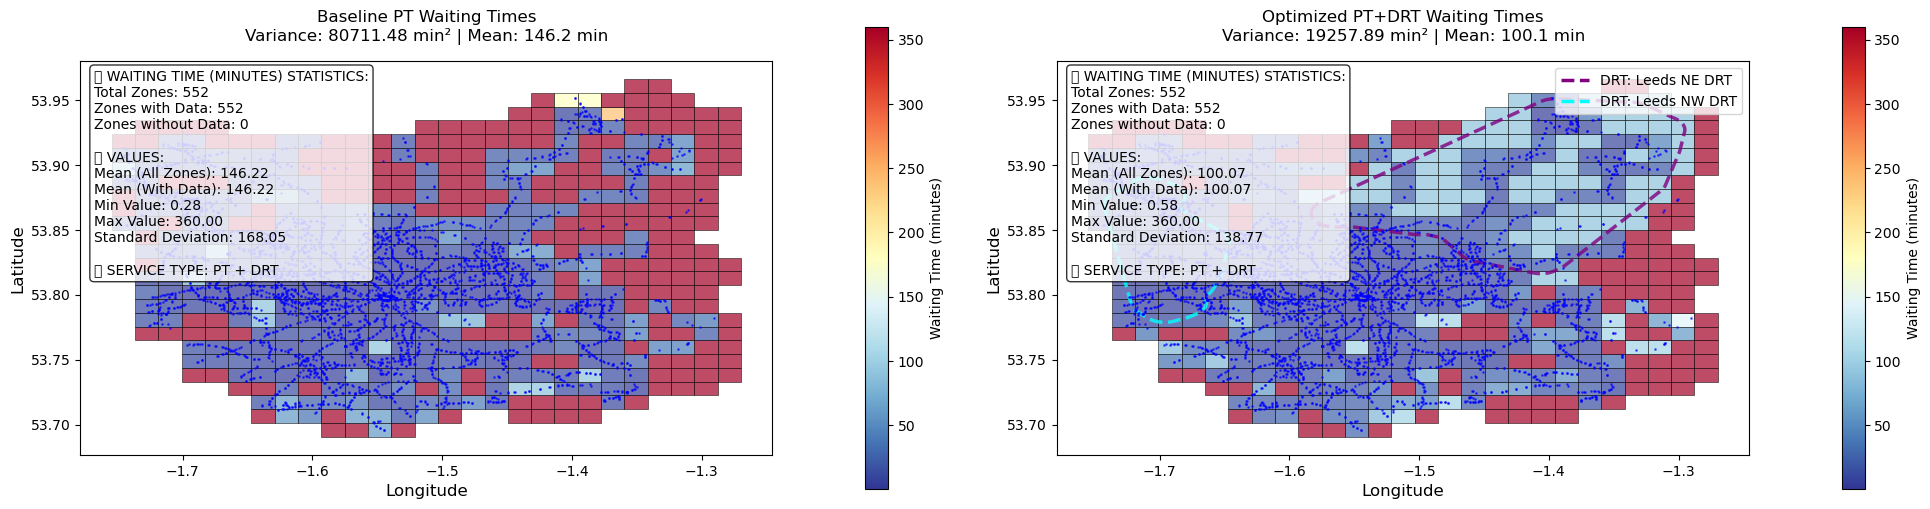


✅ Waiting time optimization visualization completed!
   • Waiting time variance improved by +76.1%
   • Mean waiting time: 146.2 → 100.1 minutes
   • Solution satisfies all constraints: True


In [14]:
# Cell 10: Compare Waiting Time Before/After Optimization using WaitingTimeObjective methods
print("\n=== WAITING TIME COMPARISON ===")

# Decode the optimized waiting time solution
optimized_waiting_solution = result_waiting_drt.best_solution

print(f"📊 WAITING TIME IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_waiting_value:.2f}")
print(f"     Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"     Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

# Calculate waiting times using WaitingTimeObjective's built-in method
baseline_waiting_times = waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = waiting_objective.get_waiting_times_per_zone(optimized_waiting_solution, "average")

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
baseline_variance_waiting = np.var(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
optimized_variance_waiting = np.var(optimized_waiting_times)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Variance: {baseline_variance_waiting:.2f} → {optimized_variance_waiting:.2f} min²")

# Use combined min/max for consistent color scaling
combined_min_waiting = min(baseline_waiting_times.min(), optimized_waiting_times.min())
combined_max_waiting = max(baseline_waiting_times.max(), optimized_waiting_times.max())

print(f"\n🎨 WAITING TIME COLOR SCALE INFO:")
print(f"   Shared color scale: {combined_min_waiting:.1f} - {combined_max_waiting:.1f} minutes")

# Create side-by-side visualization using WaitingTimeObjective's built-in method
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Baseline waiting times
waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0],
    show_stops=True,
    show_drt_zones=False,
    vmin=combined_min_waiting,
    vmax=combined_max_waiting
)
baseline_title = f'Baseline PT Waiting Times\nVariance: {baseline_waiting_value:.2f} min² | Mean: {baseline_mean_waiting:.1f} min'
axes[0].set_title(baseline_title, fontsize=12, pad=15)

# Plot 2: Optimized waiting times
waiting_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1],
    show_stops=True,
    show_drt_zones=True,
    vmin=combined_min_waiting,
    vmax=combined_max_waiting
)
optimized_title = f'Optimized PT+DRT Waiting Times\nVariance: {result_waiting_drt.best_objective:.2f} min² | Mean: {optimized_mean_waiting:.1f} min'
axes[1].set_title(optimized_title, fontsize=12, pad=15)

plt.tight_layout()
plt.show()

print(f"\n✅ Waiting time optimization visualization completed!")
print(f"   • Waiting time variance improved by {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")
print(f"   • Mean waiting time: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} minutes")
print(f"   • Solution satisfies all constraints: {result_waiting_drt.constraint_violations['feasible']}")

#### Visualise service coverage and waiting times

We compare the service coverage and waiting times before and after optimisation to see how they have changed. The DRT service area polygons are overlaid on the maps to show where DRT is operating.


=== COMPREHENSIVE WAITING TIME & SPATIAL COVERAGE COMPARISON ===
📊 WAITING TIME IMPROVEMENTS:
   Objective Value:
     Baseline: 80711.48
     Optimized: 19257.89
     Improvement: +76.1%

   Waiting Time Distribution:
     Mean waiting time: 146.22 → 100.07 min
     Change: -46.14 min

   Vehicle Coverage Distribution:
     Mean vehicles/zone: 26.51 → 18.16
     Change: -8.35 vehicles/zone

🎨 COLOR SCALES:
   Waiting times: 0.3 - 360.0 minutes
   Vehicle coverage: 0.0 - 650.8
   Waiting differences: ±351.4 minutes
   Vehicle differences: ±338.5

📍 Plotting baseline solutions...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting optimized solutions...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

📍 Plotting improvement differences...


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWAR

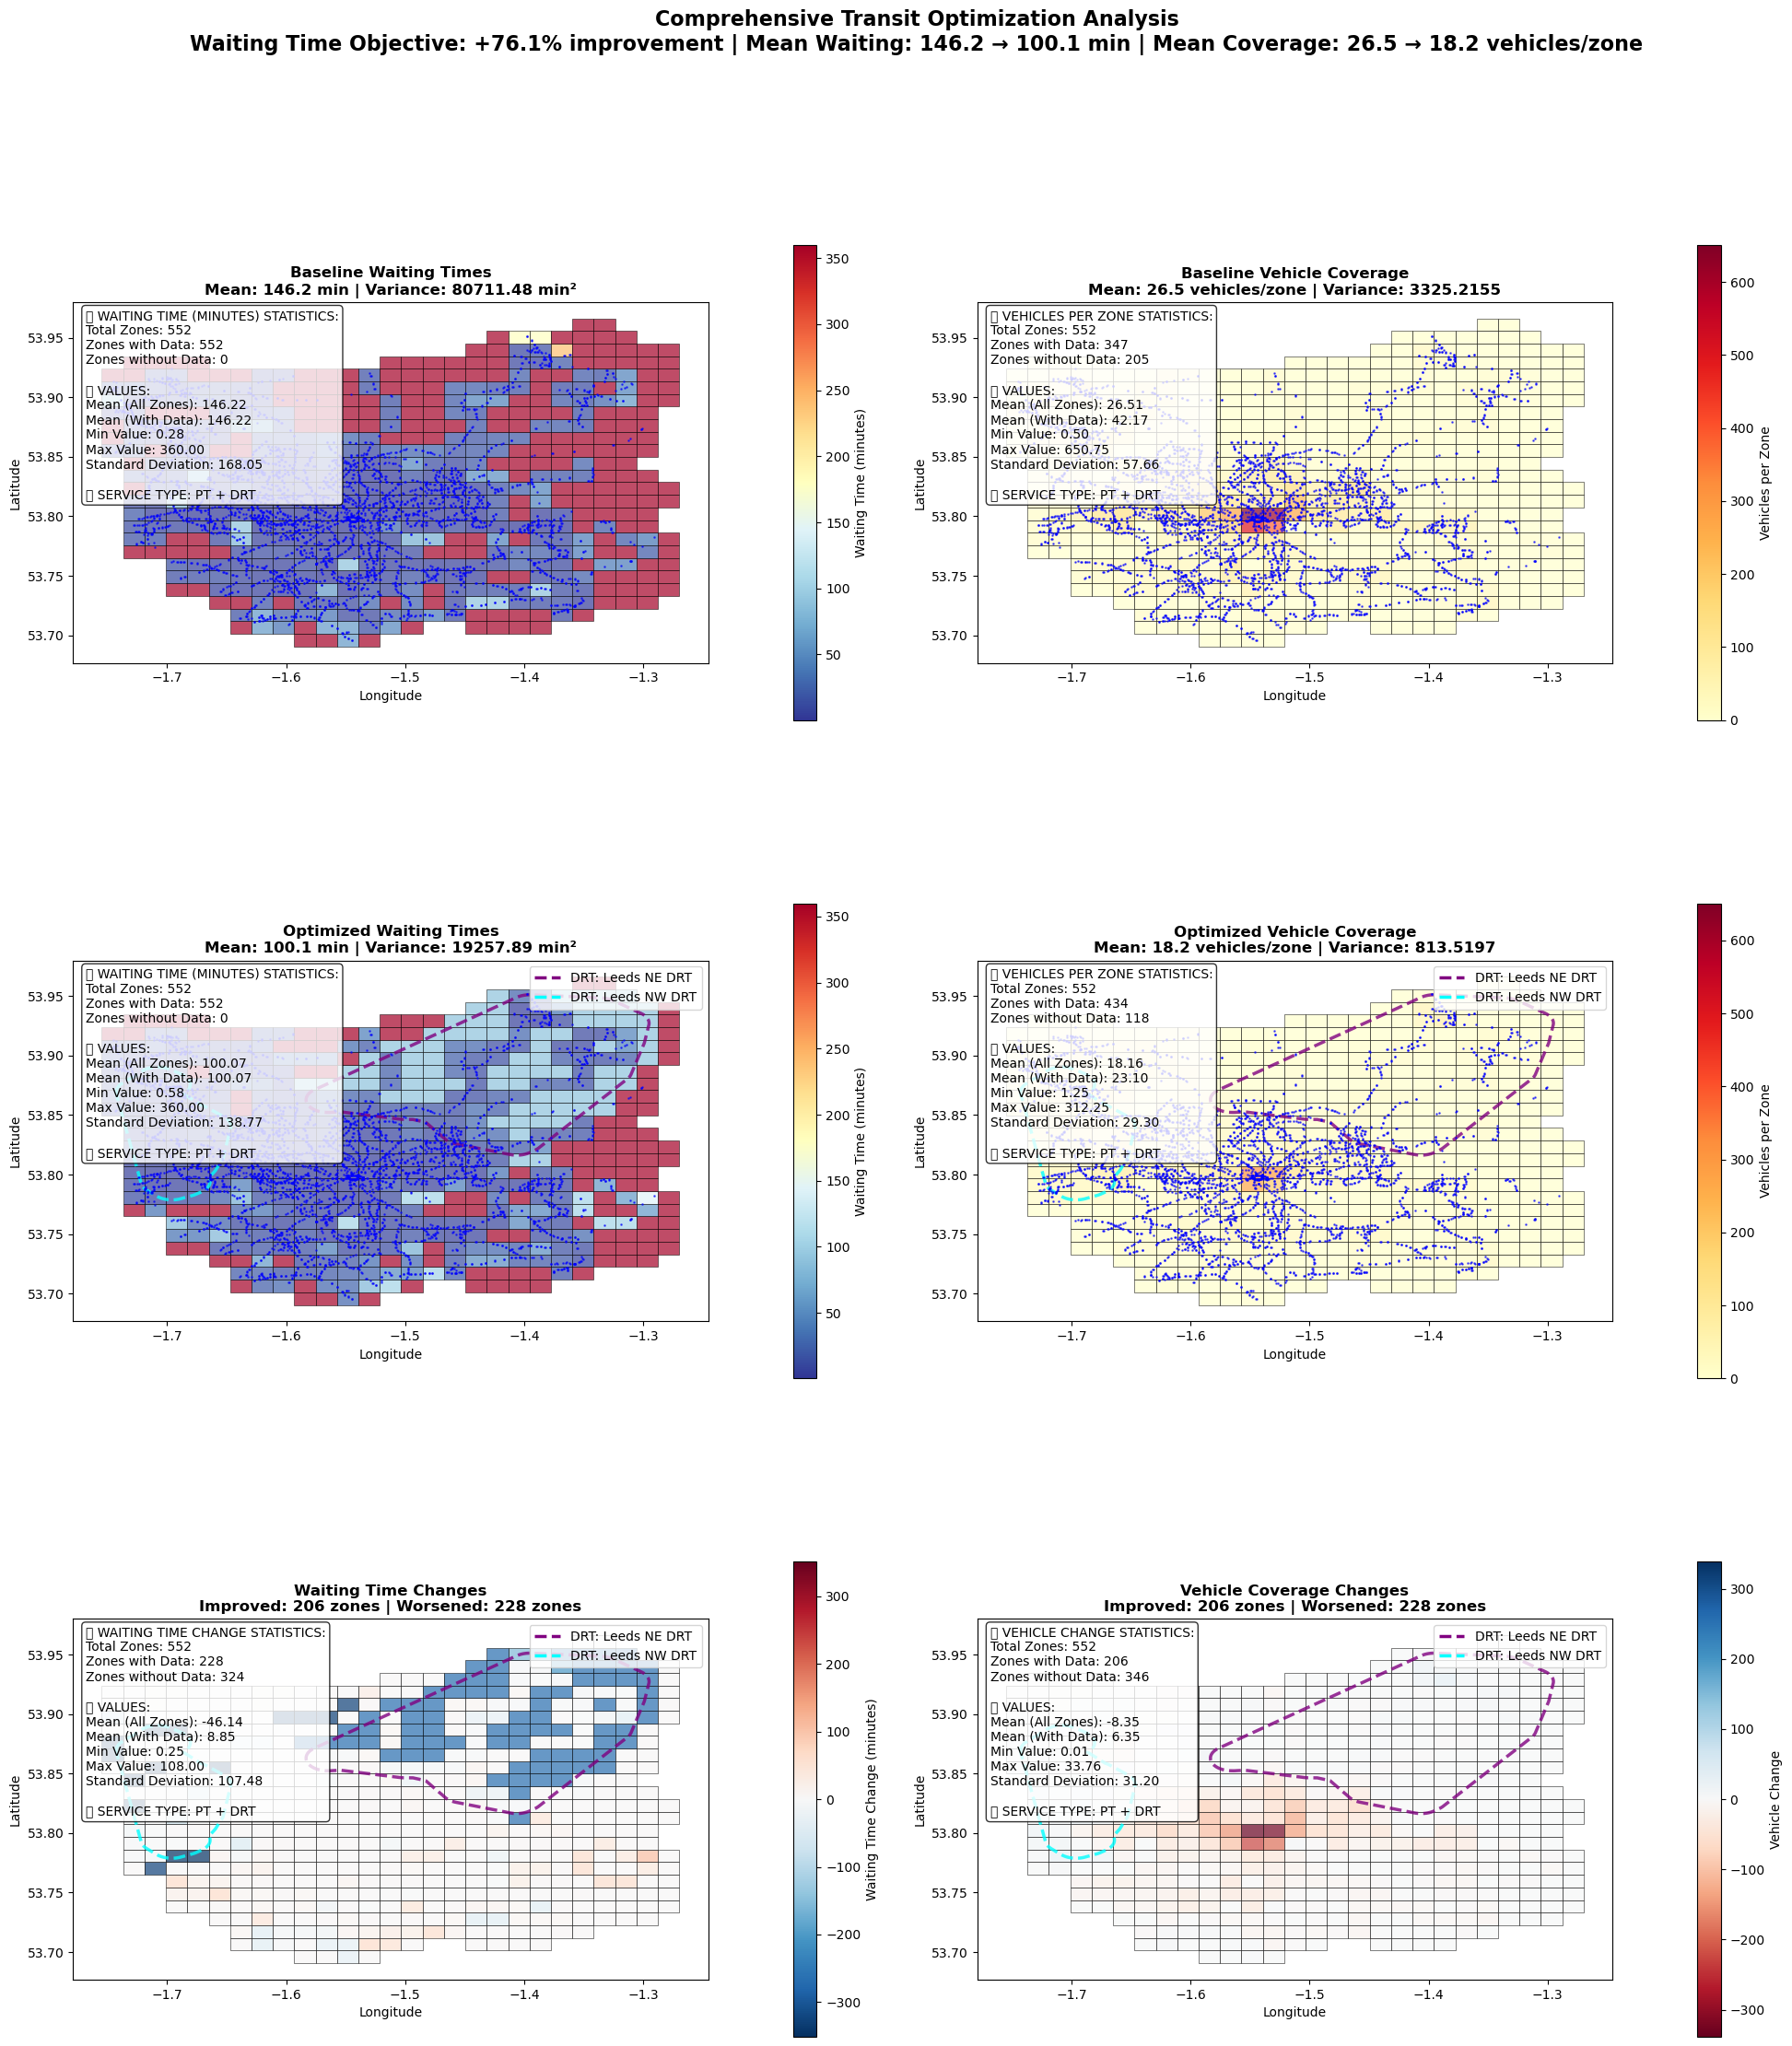


📊 COMPREHENSIVE ANALYSIS SUMMARY:
   🎯 Primary Objective (Waiting Time Variance):
      Baseline: 80711.48 → Optimized: 19257.89
      Improvement: +76.1%

   ⏱️ Waiting Time Distribution:
      Mean: 146.22 → 100.07 minutes (-46.14)
      Zones with improved waiting: 206/552 (37.3%)

   🚌 Vehicle Coverage Distribution:
      Mean: 26.51 → 18.16 vehicles/zone (-8.35)
      Zones with more vehicles: 206/552 (37.3%)

   🏆 Trade-offs Analysis:
      ✅ Waiting time improvement achieved (primary objective)
      ⚖️ Vehicle coverage change: -8.35 vehicles/zone

✅ Comprehensive visualization completed!
   📈 Top row: Baseline solutions
   📈 Middle row: Optimized solutions
   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)
   🚁 DRT zones shown in optimized and difference plots
   ✔️ Solution satisfies constraints: True


In [15]:
print("\n=== COMPREHENSIVE WAITING TIME & SPATIAL COVERAGE COMPARISON ===")

# Decode the optimized waiting time solution
optimized_waiting_solution = result_waiting_drt.best_solution

print(f"📊 WAITING TIME IMPROVEMENTS:")
print(f"   Objective Value:")
print(f"     Baseline: {baseline_waiting_value:.2f}")
print(f"     Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"     Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

# Calculate waiting times using WaitingTimeObjective's built-in method
baseline_waiting_times = waiting_objective.get_waiting_times_per_zone(decoded_solution['pt'], "average")
optimized_waiting_times = waiting_objective.get_waiting_times_per_zone(optimized_waiting_solution, "average")

# Calculate spatial coverage (vehicles per zone)
baseline_vehicles = coverage_objective.spatial_system._vehicles_per_zone(decoded_solution['pt'], opt_data)['average']
optimized_vehicles = coverage_objective.spatial_system._vehicles_per_zone(optimized_waiting_solution, opt_data)['average']

# Calculate differences
waiting_difference = optimized_waiting_times - baseline_waiting_times  # Negative = improvement
vehicle_difference = optimized_vehicles - baseline_vehicles  # Positive = improvement

# Calculate statistics
baseline_mean_waiting = np.mean(baseline_waiting_times)
optimized_mean_waiting = np.mean(optimized_waiting_times)
baseline_mean_vehicles = np.mean(baseline_vehicles)
optimized_mean_vehicles = np.mean(optimized_vehicles)

print(f"\n   Waiting Time Distribution:")
print(f"     Mean waiting time: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} min")
print(f"     Change: {optimized_mean_waiting - baseline_mean_waiting:+.2f} min")

print(f"\n   Vehicle Coverage Distribution:")
print(f"     Mean vehicles/zone: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f}")
print(f"     Change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")

# Determine shared color scales for fair comparison
waiting_vmin = min(baseline_waiting_times.min(), optimized_waiting_times.min())
waiting_vmax = max(baseline_waiting_times.max(), optimized_waiting_times.max())
vehicle_vmin = min(baseline_vehicles.min(), optimized_vehicles.min())
vehicle_vmax = max(baseline_vehicles.max(), optimized_vehicles.max())

# For difference plots, use symmetric scale around zero
waiting_diff_max = max(abs(waiting_difference.min()), abs(waiting_difference.max()))
vehicle_diff_max = max(abs(vehicle_difference.min()), abs(vehicle_difference.max()))

print(f"\n🎨 COLOR SCALES:")
print(f"   Waiting times: {waiting_vmin:.1f} - {waiting_vmax:.1f} minutes")
print(f"   Vehicle coverage: {vehicle_vmin:.1f} - {vehicle_vmax:.1f}")
print(f"   Waiting differences: ±{waiting_diff_max:.1f} minutes")
print(f"   Vehicle differences: ±{vehicle_diff_max:.1f}")

# Create comprehensive 3x2 visualization
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

# Configure overall title
overall_title = (
    f"Comprehensive Transit Optimization Analysis\n"
    f"Waiting Time Objective: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}% improvement | "
    f"Mean Waiting: {baseline_mean_waiting:.1f} → {optimized_mean_waiting:.1f} min | "
    f"Mean Coverage: {baseline_mean_vehicles:.1f} → {optimized_mean_vehicles:.1f} vehicles/zone"
)
fig.suptitle(overall_title, fontsize=16, fontweight='bold', y=0.995)

# Row 1: Baseline Solutions
print("\n📍 Plotting baseline solutions...")

# Row 1, Col 1: Baseline Waiting Times
waiting_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 0],
    show_stops=True,
    show_drt_zones=False,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[0, 0].set_title(f'Baseline Waiting Times\nMean: {baseline_mean_waiting:.1f} min | Variance: {baseline_waiting_value:.2f} min²',
                     fontsize=12, fontweight='bold')

# Row 1, Col 2: Baseline Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=decoded_solution['pt'],
    ax=axes[0, 1],
    show_stops=True,
    show_drt_zones=False,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
baseline_coverage_value = coverage_objective.evaluate(decoded_solution['pt'])
axes[0, 1].set_title(f'Baseline Vehicle Coverage\nMean: {baseline_mean_vehicles:.1f} vehicles/zone | Variance: {baseline_coverage_value:.4f}',
                     fontsize=12, fontweight='bold')

# Row 2: Optimized Solutions
print("📍 Plotting optimized solutions...")

# Row 2, Col 1: Optimized Waiting Times
waiting_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1, 0],
    show_stops=True,
    show_drt_zones=True,
    vmin=waiting_vmin,
    vmax=waiting_vmax
)
axes[1, 0].set_title(f'Optimized Waiting Times\nMean: {optimized_mean_waiting:.1f} min | Variance: {result_waiting_drt.best_objective:.2f} min²',
                     fontsize=12, fontweight='bold')

# Row 2, Col 2: Optimized Vehicle Coverage
coverage_objective.visualize(
    solution_matrix=optimized_waiting_solution,
    ax=axes[1, 1],
    show_stops=True,
    show_drt_zones=True,
    vmin=vehicle_vmin,
    vmax=vehicle_vmax
)
optimized_coverage_value = coverage_objective.evaluate(optimized_waiting_solution['pt'])
axes[1, 1].set_title(f'Optimized Vehicle Coverage\nMean: {optimized_mean_vehicles:.1f} vehicles/zone | Variance: {optimized_coverage_value:.4f}',
                     fontsize=12, fontweight='bold')

# Row 3: Differences (Improvements)
print("📍 Plotting improvement differences...")

# Row 3, Col 1: Waiting Time Difference (Optimized - Baseline)
# Negative values = improvement (shorter waiting times)
zones_with_waiting_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_waiting_diff["waiting_change"] = waiting_difference
zones_geo_waiting = zones_with_waiting_diff.to_crs("EPSG:4326")

zones_geo_waiting.plot(
    ax=axes[2, 0],
    column="waiting_change",
    cmap="RdBu_r",  # Red=increase (worse), Blue=decrease (better)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-waiting_diff_max,
    vmax=waiting_diff_max,
    legend_kwds={
        "label": "Waiting Time Change (minutes)",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 0], opt_data, True)
waiting_stats_text = coverage_objective.spatial_system._create_data_stats_text(waiting_difference, "Waiting Time Change", opt_data)
axes[2, 0].text(0.02, 0.98, waiting_stats_text, transform=axes[2, 0].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_waiting = np.sum(waiting_difference < 0)
zones_worsened_waiting = np.sum(waiting_difference > 0)
axes[2, 0].set_title(f'Waiting Time Changes\nImproved: {zones_improved_waiting} zones | Worsened: {zones_worsened_waiting} zones',
                     fontsize=12, fontweight='bold')

# Row 3, Col 2: Vehicle Coverage Difference (Optimized - Baseline)
# Positive values = improvement (more vehicles)
zones_with_vehicle_diff = coverage_objective.spatial_system.hex_grid.copy()
zones_with_vehicle_diff["vehicle_change"] = vehicle_difference
zones_geo_vehicles = zones_with_vehicle_diff.to_crs("EPSG:4326")

zones_geo_vehicles.plot(
    ax=axes[2, 1],
    column="vehicle_change",
    cmap="RdBu",  # Red=increase (better), Blue=decrease (worse)
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    vmin=-vehicle_diff_max,
    vmax=vehicle_diff_max,
    legend_kwds={
        "label": "Vehicle Change",
        "orientation": "vertical",
        "shrink": 0.6,
        "pad": 0.1,
    },
)

# Add DRT zones and statistics
coverage_objective.spatial_system._add_drt_zones_to_plot(axes[2, 1], opt_data, True)
vehicle_stats_text = coverage_objective.spatial_system._create_data_stats_text(vehicle_difference, "Vehicle Change", opt_data)
axes[2, 1].text(0.02, 0.98, vehicle_stats_text, transform=axes[2, 1].transAxes,
                verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

zones_improved_vehicles = np.sum(vehicle_difference > 0)
zones_worsened_vehicles = np.sum(vehicle_difference < 0)
axes[2, 1].set_title(f'Vehicle Coverage Changes\nImproved: {zones_improved_vehicles} zones | Worsened: {zones_worsened_vehicles} zones',
                     fontsize=12, fontweight='bold')

# Add geographic labels to all subplots
for i in range(3):
    for j in range(2):
        axes[i, j].set_xlabel("Longitude", fontsize=10)
        axes[i, j].set_ylabel("Latitude", fontsize=10)
        axes[i, j].set_aspect("equal")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.96)  # Make room for overall title
plt.show()

# Print comprehensive summary
print(f"\n📊 COMPREHENSIVE ANALYSIS SUMMARY:")
print(f"   🎯 Primary Objective (Waiting Time Variance):")
print(f"      Baseline: {baseline_waiting_value:.2f} → Optimized: {result_waiting_drt.best_objective:.2f}")
print(f"      Improvement: {((baseline_waiting_value - result_waiting_drt.best_objective) / baseline_waiting_value * 100):+.1f}%")

print(f"\n   ⏱️ Waiting Time Distribution:")
print(f"      Mean: {baseline_mean_waiting:.2f} → {optimized_mean_waiting:.2f} minutes ({optimized_mean_waiting - baseline_mean_waiting:+.2f})")
print(f"      Zones with improved waiting: {zones_improved_waiting}/{len(baseline_waiting_times)} ({100*zones_improved_waiting/len(baseline_waiting_times):.1f}%)")

print(f"\n   🚌 Vehicle Coverage Distribution:")
print(f"      Mean: {baseline_mean_vehicles:.2f} → {optimized_mean_vehicles:.2f} vehicles/zone ({optimized_mean_vehicles - baseline_mean_vehicles:+.2f})")
print(f"      Zones with more vehicles: {zones_improved_vehicles}/{len(baseline_vehicles)} ({100*zones_improved_vehicles/len(baseline_vehicles):.1f}%)")

print(f"\n   🏆 Trade-offs Analysis:")
if optimized_mean_waiting < baseline_mean_waiting and optimized_mean_vehicles > baseline_mean_vehicles:
    print("      ✅ Win-Win: Both waiting times decreased AND vehicle coverage increased")
elif optimized_mean_waiting < baseline_mean_waiting:
    print("      ✅ Waiting time improvement achieved (primary objective)")
    print(f"      ⚖️ Vehicle coverage change: {optimized_mean_vehicles - baseline_mean_vehicles:+.2f} vehicles/zone")
else:
    print("      ⚠️ Complex trade-offs detected - review spatial patterns above")

print(f"\n✅ Comprehensive visualization completed!")
print(f"   📈 Top row: Baseline solutions")
print(f"   📈 Middle row: Optimized solutions")
print(f"   📊 Bottom row: Improvements (blue=better for waiting times, red=better for vehicles)")
print(f"   🚁 DRT zones shown in optimized and difference plots")
print(f"   ✔️ Solution satisfies constraints: {result_waiting_drt.constraint_violations['feasible']}")